# <span style='color:SteelBlue'>P7 - Implémentez un modèle de scoring

## Description: 
***
L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Prêt à dépenser décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

## Mission 
***
Dans cette étude, il s'agit de developper un modèle de scoring de la probablité de défaut de paiement d'un client dans l'optique d'expliquer au client la décision ou non d'accorder un prêt. En effet, pour soutenir cette décision, la societé se basera sur des données provennat d'autres sources d'instituion financières.


## Objectif:
***
L'objectif est : 
- d'analyser le jeu de données dans le but de construire un modèle de scoring qui permettra de donner une prédiction sur la probablité de la capacité de paiement d'un client. 
- Construire un dashbord interactif permettant à la societé assez facilement d'octroyer ou non un crédit. 

## Contrainte: 
***
Pour le projet, il est donc demander d'utiliser un **Kernel Kaggle** dans le but de faire la Future selecetion assez rapidement. De ce fait, nous avons choisi le Kernel suivant: 
- Feature sélection avec Lightgbm : [Source](https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection) qui a été établi par Rishabh Rao, que nou smodifierons et l'adapterons suivant l'attente de notre projet
- Feature sélection avec BORUTA : [Source](https://www.kaggle.com/rsmits/feature-selection-with-boruta).

 # FEATURES SELECTION

Ce notebook traite de la **selection de feature** ou **feature sélection** des jeux de données des dataframes **train_set** et **test_set** composés des pré-processing (nettoyage, feature engineering)/aggrégations de tous les fichiers mis à notre disposition:

- **bureau.csv**,
- **bureau_balance.csv**,
- **credit_card_balance.csv**,
- **installments_payments.csv**,
- **POS_CASH_balance.csv**,
- **previous_application.csv**

Notes :
***
- **Feature selection** : outre la génération de caractéristiques importantes/utiles, il est également essentiel de supprimer les caractéristiques redondantes et bruyantes. Si nous introduisons des déchets/bruits dans notre modèle d'apprentissage automatique, il retournera des déchets/bruits. Nous devons donc trouver de bonnes techniques de sélection des caractéristiques les plus importantes et discriminantes pour notre problématique.

***
Sources
***
Kernel Kaggle sur Home Credit :
- Feature sélection avec Lightgbm : [Source](https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection)
- Feature sélection avec BORUTA : [Source](https://www.kaggle.com/rsmits/feature-selection-with-boruta).
- Feature sélection avec BOOSTAROOTA : [Source](https://github.com/Murfin/nn_project/blob/master/NN%20project%20notebook%20ver.%202.ipynb)

In [1]:
# Chargement des librairies
import datetime
import sys
import time
from datetime import datetime
import warnings
#import jyquickhelper
import numpy as np
import pandas as pd
import os
import outils_data
import outils_preprocessing
import outils_model
import eda_kernel_fonctions
import pickle

import matplotlib.pyplot as plt

# Modelisation
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Features selection
from boruta import BorutaPy
from BorutaShap import BorutaShap
from collections import Counter

# Warnings
warnings.filterwarnings('ignore')

In [2]:
# Versions
print('Version des librairies utilisées :')
#print('jyquickhelper         : ' + jyquickhelper.__version__)
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Lightgbm              : ' + lgb.__version__)
print('Outils dataframe      : ' + outils_data.__version__)
print('Outils pré-processing : ' + outils_preprocessing.__version__)
print('Outils model          : ' + outils_model.__version__)
print('EDA Kernel fonctions  : ' + eda_kernel_fonctions.__version__)
now = datetime.now().isoformat()
print('Lancé le           : ' + now)

Version des librairies utilisées :
Python                : 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
NumPy                 : 1.21.5
Pandas                : 1.4.2
Lightgbm              : 3.3.0
Outils dataframe      : 0.0.4
Outils pré-processing : 0.0.0
Outils model          : 0.0.1
EDA Kernel fonctions  : 0.0.0
Lancé le           : 2022-06-18T11:42:15.933527


In [3]:
dico_pd_option = {
    'display.max_rows': 400,
    'display.max_column': 200,
    'display.width': 300,
    'display.precision': 4,
    'display.max_colwidth': 1000,
    'mode.chained_assignment': None
}
for cle, val in dico_pd_option.items():
    pd.set_option(cle, val)

## Chargement des jeux de données

**Chargement des dataframes nettoyés**

In [4]:
fic_sav_train_set = \
    'sauvegarde/pre-processing/train_set_preproc.pickle'
# Chargement de train_set
with open(fic_sav_train_set, 'rb') as df_appli_train_set:
    train_set = pickle.load(df_appli_train_set)
train_set.shape

(307507, 615)

In [5]:
fic_sav_appli_train_imp1 = \
    'sauvegarde/pre-processing/train_imp1_set_preproc.pickle'
# Chargement de train_imp1_set
with open(fic_sav_appli_train_imp1, 'rb') as df_appli_train_imp1_set:
    train_imp1_set = pickle.load(df_appli_train_imp1_set)
train_imp1_set.shape

(307507, 622)

In [6]:
fic_sav_appli_train_imp2 = \
    'sauvegarde/pre-processing/train_imp2_set_preproc.pickle'
# Chargement de train_imp2_set
with open(fic_sav_appli_train_imp2, 'rb') as df_appli_train_imp2_set:
    train_imp2_set = pickle.load(df_appli_train_imp2_set)
train_imp2_set.shape

(307507, 617)

In [7]:
fic_sav_test_set = \
    'sauvegarde/pre-processing/test_set_preproc.pickle'
# Chargement de test_set
with open(fic_sav_test_set, 'rb') as df_appli_test_set:
    test_set = pickle.load(df_appli_test_set)
test_set.shape

(48744, 614)

In [8]:
fic_sav_appli_test_imp1 = \
    'sauvegarde/pre-processing/test_imp1_set_preproc.pickle'
# Chargement de test_imp1_set
with open(fic_sav_appli_test_imp1, 'rb') as df_appli_test_imp1_set:
    test_imp1_set = pickle.load(df_appli_test_imp1_set)
test_imp1_set.shape

(48744, 621)

In [9]:
fic_sav_appli_test_imp2 = \
    'sauvegarde/pre-processing/test_imp2_set_preproc.pickle'
# Chargement de test_imp2_set
with open(fic_sav_appli_test_imp2, 'rb') as df_appli_test_imp2_set:
    test_imp2_set = pickle.load(df_appli_test_imp2_set)
test_imp2_set.shape

(48744, 618)

## Features selection

###  Features selection : avec LIGHTGBM

- Extrait du Kernel Kaggle : [Source](https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection)
- Le but est de conserver uniquement les variables les plus pertinentes en utilisant les features importantes déterminées par un modèle, Lightgbm dans notre cas.

#### Train_set/test_set

Notes:
***
- La variable magique TARGET_NEIGHBORS_500_MEAN peut être controverser par un client sur le recueil des données des autres clients et difficile à expliquer facilement à un client donc nous allons tester avec ou sans cette variable à chaque fois qu'on determinera les futures importantes.

##### Sans la variable magique TARGET_NEIGHBORS_500_MEAN**

**Préparation des dataframes de travail**

In [10]:
# Résumé des variables qualitatives
desc_train_set = outils_data.description_variables(train_set)
desc_train_set

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,NONLIVINGAREA_AVG,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,ANNUITY_INCOME_RATIO,CREDIT_GOODS_RATIO,INCOME_GOODS_DIFF,INCOME_EXT_RATIO,LAST_PHONE_EMPLOYED_RATIO,CAR_EMPLOYED_RATIO,FLAG_CONTACTS_SUM,CNT_NON_CHILDREN,EXT_SOURCE_SUM,EXT_SOURCE_MAX,EXT_SOURCE_VAR,OBS_DEF_30_MUL,OBS_30_CREDIT_RATIO,FLAGS_DOCUMENTS_SUM,ENQ_CREDIT_RATIO,TARGET_NEIGHBORS_500_MEAN,NAME_TYPE_SUITE_CHILDREN,NAME_TYPE_SUITE_FAMILY,NAME_TYPE_SUITE_GROUP_OF_PEOPLE,NAME_TYPE_SUITE_OTHER_A,NAME_TYPE_SUITE_OTHER_B,NAME_TYPE_SUITE_SPOUSE_PARTNER,NAME_INCOME_TYPE_BUSINESSMAN,NAME_INCOME_TYPE_COMMERCIAL_ASSOCIATE,NAME_INCOME_TYPE_STATE_SERVANT,NAME_INCOME_TYPE_STUDENT,NAME_INCOME_TYPE_UNEMPLOYED,NAME_INCOME_TYPE_WORKING,...,PREV_APP_DAYS_DECISION_MAX,PREV_APP_SELLERPLACE_AREA_MEAN,PREV_APP_SELLERPLACE_AREA_MIN,PREV_APP_CNT_PAYMENT_MEAN,PREV_APP_NAME_YIELD_GROUP_MEAN,PREV_APP_NAME_YIELD_GROUP_LAST,PREV_APP_DAYS_FIRST_DUE_SUM,PREV_APP_DAYS_LAST_DUE_MAX,PREV_APP_NFLAG_INSURED_ON_APPROVAL_SUM,PREV_APP_AMT_DECLINED_MEAN,PREV_APP_AMT_DECLINED_SUM,PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN,PREV_APP_AMT_CREDIT_GOODS_RATIO_MAX,PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN,PREV_APP_AMT_CREDIT_GOODS_DIFF_SUM,PREV_APP_AMT_CREDIT_GOODS_DIFF_MEAN,PREV_APP_AMT_CREDIT_GOODS_DIFF_MAX,PREV_APP_AMT_CREDIT_APPLICATION_RATIO_MEAN,PREV_APP_AMT_CREDIT_APPLICATION_RATIO_MIN,PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MEAN,PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MIN,PREV_APP_AMT_APPLICATION_TO_SELLERPLACE_AREA_MEAN,PREV_APP_ANNUITY_MEAN,PREV_APP_ANNUITY_GOODS_MEAN,PREV_APP_LOAN_RATE_MAX,PREV_APP_LOAN_RATE_MEAN,PREV_APP_DAYS_FIRST_LAST_DUE_DIFF_MEAN,PREV_APP_AMT_INTEREST_MEAN,PREV_APP_INTEREST_SHARE_MEAN,PREV_APP_INTEREST_SHARE_MAX,PREV_APP_INTEREST_SHARE_MIN,PREV_APP_INTEREST_RATE_MAX,PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MIN_MEAN,PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MAX_MEAN,PKPRET_BUREAU_BALANCE_STATUS_MAX_MEAN,PKPRET_BUREAU_BALANCE_STATUS_MEAN_MEAN,PKPRET_BUREAU_BALANCE_STATUS_LAST_MEAN,PKPRET_BUREAU_BALANCE_STATUS_SUM_MEAN,PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_MEAN_MEAN,PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_LAST_MEAN,BUREAU_CREDIT_ACTIVE_ACTIVE_SUM,BUREAU_CREDIT_ACTIVE_ACTIVE_COUNT,BUREAU_CREDIT_ACTIVE_ACTIVE_MEAN,BUREAU_CREDIT_ACTIVE_BAD_DEBT_SUM,BUREAU_CREDIT_ACTIVE_SOLD_SUM,BUREAU_CREDIT_ACTIVE_SOLD_MEAN,BUREAU_CREDIT_CURRENCY_CURRENCY_1_MEAN,BUREAU_CREDIT_CURRENCY_CURRENCY_2_SUM,BUREAU_CREDIT_CURRENCY_CURRENCY_3_SUM,BUREAU_CREDIT_CURRENCY_CURRENCY_3_MEAN,BUREAU_CREDIT_CURRENCY_CURRENCY_4_SUM,BUREAU_CREDIT_TYPE_ANOTHER_TYPE_OF_LOAN_SUM,BUREAU_CREDIT_TYPE_ANOTHER_TYPE_OF_LOAN_MEAN,BUREAU_CREDIT_TYPE_CAR_LOAN_SUM,BUREAU_CREDIT_TYPE_CAR_LOAN_MEAN,BUREAU_CREDIT_TYPE_CASH_LOAN_NON_EARMARKED__SUM,BUREAU_CREDIT_TYPE_CONSUMER_CREDIT_MEAN,BUREAU_CREDIT_TYPE_CREDIT_CARD_SUM,BUREAU_CREDIT_TYPE_INTERBANK_CREDIT_SU

In [11]:
# Dataframes de travail
train_sans_fs_lgbm = train_set.copy()
train_sans_fs_lgbm = train_sans_fs_lgbm.drop(['TARGET_NEIGHBORS_500_MEAN'],
                                             axis=1)
print(f'train_sans_fs_lgbm : {train_sans_fs_lgbm.shape}')
test_sans_fs_lgbm = test_set.copy()
test_sans_fs_lgbm = test_sans_fs_lgbm.drop(['TARGET_NEIGHBORS_500_MEAN'],
                                           axis=1)
print(f'test_sans_fs_lgbm : {test_sans_fs_lgbm.shape}')

train_sans_fs_lgbm : (307507, 614)
test_sans_fs_lgbm : (48744, 613)


In [12]:
# Sauvegarde des étiquettes car l'alignement supprimera cette variable.
train_sans_fs_lgbm_labels = train_sans_fs_lgbm['TARGET']

# Sauvegarde des identifiants
train_sans_fs_lgbm_ids = train_sans_fs_lgbm['SK_ID_CURR']
test_sans_fs_lgbm_ids = test_sans_fs_lgbm['SK_ID_CURR']

# Alignement des dataframes (suppression variable TARGET)
train_sans_fs_lgbm, test_sans_fs_lgbm = \
    train_sans_fs_lgbm.align(test_sans_fs_lgbm, join='inner', axis=1)

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_sans_fs_lgbm = train_sans_fs_lgbm.drop(columns=['SK_ID_CURR'])
test_sans_fs_lgbm = test_sans_fs_lgbm.drop(columns=['SK_ID_CURR'])

print(f'train_fs_lgbm : {train_sans_fs_lgbm.shape}')
print(f'test_fs_lgbm : {test_sans_fs_lgbm.shape}')

train_fs_lgbm : (307507, 612)
test_fs_lgbm : (48744, 612)


**Modélisation**

***Premier passage***

In [13]:
# Initialiser un tableau vide pour contenir les features importance
feature_importances_sans = np.zeros(train_sans_fs_lgbm.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='goss',
                           n_estimators=10000,
                           class_weight='balanced')

In [14]:
# Entraînement du modèle deux fois pour éviter l'overfitting
for i in range(2):

    # Split en jeux d'entraînement et de validation
    train_sans_features, valid_sans_features, train_sans_y, valid_sans_y = \
        train_test_split(train_sans_fs_lgbm, train_sans_fs_lgbm_labels,
                         test_size=0.25, random_state=i)

    # Entraînement en utilisant early stopping
    model.fit(train_sans_features, train_sans_y,
              early_stopping_rounds=100,
              eval_set=[(valid_sans_features, valid_sans_y)],
              eval_metric='auc', verbose=200)

    # Sauvegarde des features importances
    feature_importances_sans += model.feature_importances_

[200]	valid_0's auc: 0.79147	valid_0's binary_logloss: 0.507301
[200]	valid_0's auc: 0.786173	valid_0's binary_logloss: 0.505428


In [15]:
# Assurez-vous de faire la moyenne des features importance !
# puisque le modèle a été entraîné 2 fois
feature_importances_sans = feature_importances_sans / 2
df_fs_sans_lightgbm = \
    pd.DataFrame({'feature': list(train_sans_fs_lgbm.columns),
                  'importance': feature_importances_sans}) \
    .sort_values('importance', ascending=False)

df_fs_sans_lightgbm.head()

,feature,importance
69,CREDIT_ANNUITY_RATIO,131.0
78,EXT_SOURCE_SUM,102.5
253,INST_PAY_DAYS_PAYMENT_RATIO_MAX,86.5
9,DAYS_BIRTH,75.5
541,PREV_APP_INTEREST_SHARE_MAX,65.5


In [16]:
# Exploration des variables avec zéro importance
zero_features_sans = \
    list(df_fs_sans_lightgbm[df_fs_sans_lightgbm['importance'] == 0.0][
        'feature'])
print(f'{len(zero_features_sans)} variables avec 0.0 importance :\n')
zero_features_sans

214 variables avec 0.0 importance :



['NAME_HOUSING_TYPE_WITH_PARENTS',
 'PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITH_INTEREST_SUM',
 'OCCUPATION_TYPE_ACCOUNTANTS',
 'OCCUPATION_TYPE_HR_STAFF',
 'OCCUPATION_TYPE_IT_STAFF',
 'OCCUPATION_TYPE_COOKING_STAFF',
 'OCCUPATION_TYPE_CLEANING_STAFF',
 'ORGANIZATION_TYPE_INDUSTRY_TYPE_12',
 'OCCUPATION_TYPE_PRIVATE_SERVICE_STAFF',
 'ORGANIZATION_TYPE_CLEANING',
 'ORGANIZATION_TYPE_INDUSTRY_TYPE_11',
 'ORGANIZATION_TYPE_INDUSTRY_TYPE_10',
 'ORGANIZATION_TYPE_INDUSTRY_TYPE_1',
 'PREV_APP_PRODUCT_COMBINATION_POS_OTHER_WITH_INTEREST_SUM',
 'ORGANIZATION_TYPE_EMERGENCY',
 'ORGANIZATION_TYPE_CULTURE',
 'PREV_APP_NFLAG_LAST_APPL_IN_DAY_MEAN',
 'ORGANIZATION_TYPE_INDUSTRY_TYPE_13',
 'ORGANIZATION_TYPE_BUSINESS_ENTITY_TYPE_2',
 'OCCUPATION_TYPE_REALTY_AGENTS',
 'NAME_HOUSING_TYPE_CO_OP_APARTMENT',
 'ORGANIZATION_TYPE_AGRICULTURE',
 'ORGANIZATION_TYPE_ADVERTISING',
 'PREV_APP_PRODUCT_COMBINATION_POS_OTHERS_WITHOUT_INTEREST_SUM',
 'ORGANIZATION_TYPE_INDUSTRY_TYPE_2',
 'OCCUPATION_TYPE_WAITE

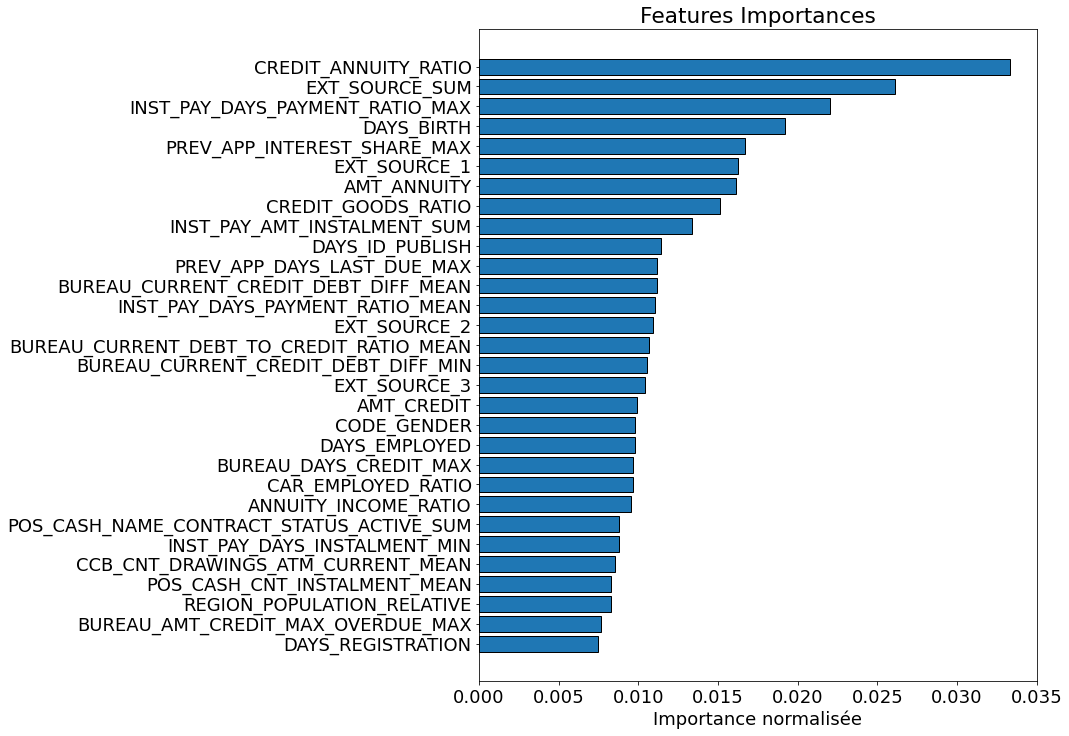

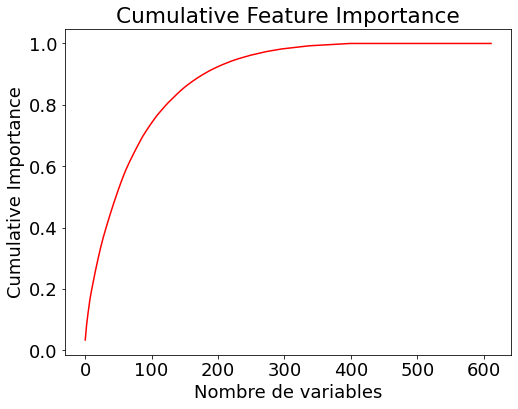

180 variables nécessaires pour 0.90 de cumulative importance


In [17]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_sans_lightgbm_norm = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_sans_lightgbm)

In [18]:
# Suppression des variables avec zéro importance
train_sans_fs_lgbm = train_sans_fs_lgbm.drop(columns=zero_features_sans)
test_sans_fs_lgbm = test_sans_fs_lgbm.drop(columns=zero_features_sans)

print(f'train_sans_fs_lgbm : {train_sans_fs_lgbm.shape}')
print(f'test_sans_fs_lgbm : {test_sans_fs_lgbm.shape}')

train_sans_fs_lgbm : (307507, 398)
test_sans_fs_lgbm : (48744, 398)


***Second passage***

In [19]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_2_sans, df_fs_sans_lightgbm_2 = eda_kernel_fonctions \
    .identify_zero_importance_features(train_sans_fs_lgbm,
                                       train_sans_fs_lgbm_labels)

[200]	valid_0's auc: 0.792242	valid_0's binary_logloss: 0.506136
[200]	valid_0's auc: 0.786304	valid_0's binary_logloss: 0.504963

There are 0 features with 0.0 importance


**Sauvegarde**

In [20]:
# Sauvegarde des features importances avec lightgbm
fic_sav_fs_sans_lightgbm = \
    'sauvegarde/features-selection/fs_sans_lightgbm.pickle'
with open(fic_sav_fs_sans_lightgbm, 'wb') as f:
    pickle.dump(df_fs_sans_lightgbm_2, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [21]:
# Chargement des features importance de ligthgbm
fic_sav_fs_sans_lightgbm = \
    'sauvegarde/features-selection/fs_sans_lightgbm.pickle'
# Chargement des features importance
with open(fic_sav_fs_sans_lightgbm, 'rb') as df_fs_sans_lightgbm:
    df_fs_sans_lightgbm = pickle.load(df_fs_sans_lightgbm)
df_fs_sans_lightgbm.shape

(398, 2)

In [22]:
# Sauvegarde du nombre de features importance
df_fs_sans_train_set = pd.DataFrame({})
df_fs_sans_train_set = \
    outils_preprocessing.tracer_features_importance(df_fs_sans_lightgbm,
                                                    df_fs_sans_train_set,
                                                    'train_sans_set',
                                                    'lightgbm')

train_sans_set - lightgbm : 398 variables importantes conservées


**Avec la variable magique TARGET_NEIGHBORS_500_MEAN**

**Préparation des dataframes de travail**

In [23]:
# Résumé des variables qualitatives
desc_train_set = outils_data.description_variables(train_set)
desc_train_set

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,NONLIVINGAREA_AVG,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,ANNUITY_INCOME_RATIO,CREDIT_GOODS_RATIO,INCOME_GOODS_DIFF,INCOME_EXT_RATIO,LAST_PHONE_EMPLOYED_RATIO,CAR_EMPLOYED_RATIO,FLAG_CONTACTS_SUM,CNT_NON_CHILDREN,EXT_SOURCE_SUM,EXT_SOURCE_MAX,EXT_SOURCE_VAR,OBS_DEF_30_MUL,OBS_30_CREDIT_RATIO,FLAGS_DOCUMENTS_SUM,ENQ_CREDIT_RATIO,TARGET_NEIGHBORS_500_MEAN,NAME_TYPE_SUITE_CHILDREN,NAME_TYPE_SUITE_FAMILY,NAME_TYPE_SUITE_GROUP_OF_PEOPLE,NAME_TYPE_SUITE_OTHER_A,NAME_TYPE_SUITE_OTHER_B,NAME_TYPE_SUITE_SPOUSE_PARTNER,NAME_INCOME_TYPE_BUSINESSMAN,NAME_INCOME_TYPE_COMMERCIAL_ASSOCIATE,NAME_INCOME_TYPE_STATE_SERVANT,NAME_INCOME_TYPE_STUDENT,NAME_INCOME_TYPE_UNEMPLOYED,NAME_INCOME_TYPE_WORKING,...,PREV_APP_DAYS_DECISION_MAX,PREV_APP_SELLERPLACE_AREA_MEAN,PREV_APP_SELLERPLACE_AREA_MIN,PREV_APP_CNT_PAYMENT_MEAN,PREV_APP_NAME_YIELD_GROUP_MEAN,PREV_APP_NAME_YIELD_GROUP_LAST,PREV_APP_DAYS_FIRST_DUE_SUM,PREV_APP_DAYS_LAST_DUE_MAX,PREV_APP_NFLAG_INSURED_ON_APPROVAL_SUM,PREV_APP_AMT_DECLINED_MEAN,PREV_APP_AMT_DECLINED_SUM,PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN,PREV_APP_AMT_CREDIT_GOODS_RATIO_MAX,PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN,PREV_APP_AMT_CREDIT_GOODS_DIFF_SUM,PREV_APP_AMT_CREDIT_GOODS_DIFF_MEAN,PREV_APP_AMT_CREDIT_GOODS_DIFF_MAX,PREV_APP_AMT_CREDIT_APPLICATION_RATIO_MEAN,PREV_APP_AMT_CREDIT_APPLICATION_RATIO_MIN,PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MEAN,PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MIN,PREV_APP_AMT_APPLICATION_TO_SELLERPLACE_AREA_MEAN,PREV_APP_ANNUITY_MEAN,PREV_APP_ANNUITY_GOODS_MEAN,PREV_APP_LOAN_RATE_MAX,PREV_APP_LOAN_RATE_MEAN,PREV_APP_DAYS_FIRST_LAST_DUE_DIFF_MEAN,PREV_APP_AMT_INTEREST_MEAN,PREV_APP_INTEREST_SHARE_MEAN,PREV_APP_INTEREST_SHARE_MAX,PREV_APP_INTEREST_SHARE_MIN,PREV_APP_INTEREST_RATE_MAX,PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MIN_MEAN,PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MAX_MEAN,PKPRET_BUREAU_BALANCE_STATUS_MAX_MEAN,PKPRET_BUREAU_BALANCE_STATUS_MEAN_MEAN,PKPRET_BUREAU_BALANCE_STATUS_LAST_MEAN,PKPRET_BUREAU_BALANCE_STATUS_SUM_MEAN,PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_MEAN_MEAN,PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_LAST_MEAN,BUREAU_CREDIT_ACTIVE_ACTIVE_SUM,BUREAU_CREDIT_ACTIVE_ACTIVE_COUNT,BUREAU_CREDIT_ACTIVE_ACTIVE_MEAN,BUREAU_CREDIT_ACTIVE_BAD_DEBT_SUM,BUREAU_CREDIT_ACTIVE_SOLD_SUM,BUREAU_CREDIT_ACTIVE_SOLD_MEAN,BUREAU_CREDIT_CURRENCY_CURRENCY_1_MEAN,BUREAU_CREDIT_CURRENCY_CURRENCY_2_SUM,BUREAU_CREDIT_CURRENCY_CURRENCY_3_SUM,BUREAU_CREDIT_CURRENCY_CURRENCY_3_MEAN,BUREAU_CREDIT_CURRENCY_CURRENCY_4_SUM,BUREAU_CREDIT_TYPE_ANOTHER_TYPE_OF_LOAN_SUM,BUREAU_CREDIT_TYPE_ANOTHER_TYPE_OF_LOAN_MEAN,BUREAU_CREDIT_TYPE_CAR_LOAN_SUM,BUREAU_CREDIT_TYPE_CAR_LOAN_MEAN,BUREAU_CREDIT_TYPE_CASH_LOAN_NON_EARMARKED__SUM,BUREAU_CREDIT_TYPE_CONSUMER_CREDIT_MEAN,BUREAU_CREDIT_TYPE_CREDIT_CARD_SUM,BUREAU_CREDIT_TYPE_INTERBANK_CREDIT_SU

In [24]:
# Dataframes de travail
train_fs_lgbm = train_set.copy()
print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
test_fs_lgbm = test_set.copy()
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

train_fs_lgbm : (307507, 615)
test_fs_lgbm : (48744, 614)


In [25]:
# Sauvegarde des étiquettes car l'alignement supprimera
# cette variable.
train_fs_lgbm_labels = train_fs_lgbm['TARGET']

# Sauvegarde des identifiants
train_fs_lgbm_ids = train_fs_lgbm['SK_ID_CURR']
test_fs_lgbm_ids = test_fs_lgbm['SK_ID_CURR']

# Alignement des dataframes (suppression variable TARGET)
train_fs_lgbm, test_fs_lgbm = train_fs_lgbm.align(test_fs_lgbm,
                                                  join='inner', axis=1)

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_fs_lgbm = train_fs_lgbm.drop(columns=['SK_ID_CURR'])
test_fs_lgbm = test_fs_lgbm.drop(columns=['SK_ID_CURR'])

print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

train_fs_lgbm : (307507, 613)
test_fs_lgbm : (48744, 613)


**Modélisation**

***Premier passage***

In [26]:
# Initialiser un tableau vide pour contenir les features importance
feature_importances = np.zeros(train_fs_lgbm.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='goss',
                           n_estimators=10000,
                           class_weight='balanced')

In [27]:
# Entraînement du modèle deux fois pour éviter l'overfitting
for i in range(2):

    # Split en jeux d'entraînement et de validation
    train_features, valid_features, train_y, valid_y = \
        train_test_split(train_fs_lgbm, train_fs_lgbm_labels,
                         test_size=0.25, random_state=i)

    # Entraînement en utilisant early stopping
    model.fit(train_features, train_y,
              early_stopping_rounds=100,
              eval_set=[(valid_features, valid_y)],
              eval_metric='auc', verbose=200)

    # Sauvegarde des features importances
    feature_importances += model.feature_importances_

[200]	valid_0's auc: 0.797097	valid_0's binary_logloss: 0.502357
[200]	valid_0's auc: 0.791248	valid_0's binary_logloss: 0.500058


In [28]:
# Assurez-vous de faire la moyenne des features importance !
# puisque le modèle a été entraîné 2 fois
feature_importances = feature_importances / 2
df_fs_lightgbm = \
    pd.DataFrame({'feature': list(train_fs_lgbm.columns),
                  'importance': feature_importances}) \
    .sort_values('importance', ascending=False)

df_fs_lightgbm.head()

,feature,importance
85,TARGET_NEIGHBORS_500_MEAN,162.5
9,DAYS_BIRTH,90.0
254,INST_PAY_DAYS_PAYMENT_RATIO_MAX,87.0
78,EXT_SOURCE_SUM,73.0
7,AMT_ANNUITY,71.0


In [29]:
# Exploration des variables avec zéro importance
# Find the features with zero importance
zero_features = \
    list(df_fs_lightgbm[df_fs_lightgbm['importance'] == 0.0]['feature'])
print(f'{len(zero_features)} variables avec 0.0 importance :\n')
zero_features

189 variables avec 0.0 importance :



['BUREAU_CREDIT_TYPE_CASH_LOAN_NON_EARMARKED__SUM',
 'BUREAU_CREDIT_CURRENCY_CURRENCY_3_MEAN',
 'FLAG_DOCUMENT_20',
 'FLAG_CONT_MOBILE',
 'BUREAU_CREDIT_CURRENCY_CURRENCY_4_SUM',
 'BUREAU_CREDIT_TYPE_CAR_LOAN_SUM',
 'BUREAU_FLAG_OVERDUE_RECENT_SUM',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'FLAG_DOCUMENT_21',
 'BUREAU_CREDIT_CURRENCY_CURRENCY_3_SUM',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'BUREAU_CREDIT_CURRENCY_CURRENCY_1_MEAN',
 'BUREAU_CREDIT_CURRENCY_CURRENCY_2_SUM',
 'FLAG_DOCUMENT_17',
 'PREV_APP_PRODUCT_COMBINATION_POS_MOBILE_WITHOUT_INTEREST_SUM',
 'FLAG_DOCUMENT_12',
 'FLAG_MOBIL',
 'BUREAU_CURRENT_AMT_OVERDUE_DURATION_RATIO_SUM',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_14',
 'OCCUPATION_TYPE_WAITERS_BARMEN_STAFF',
 'BUREAU_CREDIT_ACTIVE_BAD_DEBT_SUM',
 'NAME_HOUSING_TYPE_CO_OP_APARTMENT',
 'PREV_APP_PRODUCT_COMBINATION_POS_OTHERS_WITHOUT_INTEREST_SUM',
 'FLAG_DOCUMENT_10',
 'BUREAU_CREDIT_TYPE_INTERBANK_CREDIT_SUM',
 'OCCUPATION_TYPE_IT_STAFF',
 'FLAG_DOCUMENT_5'

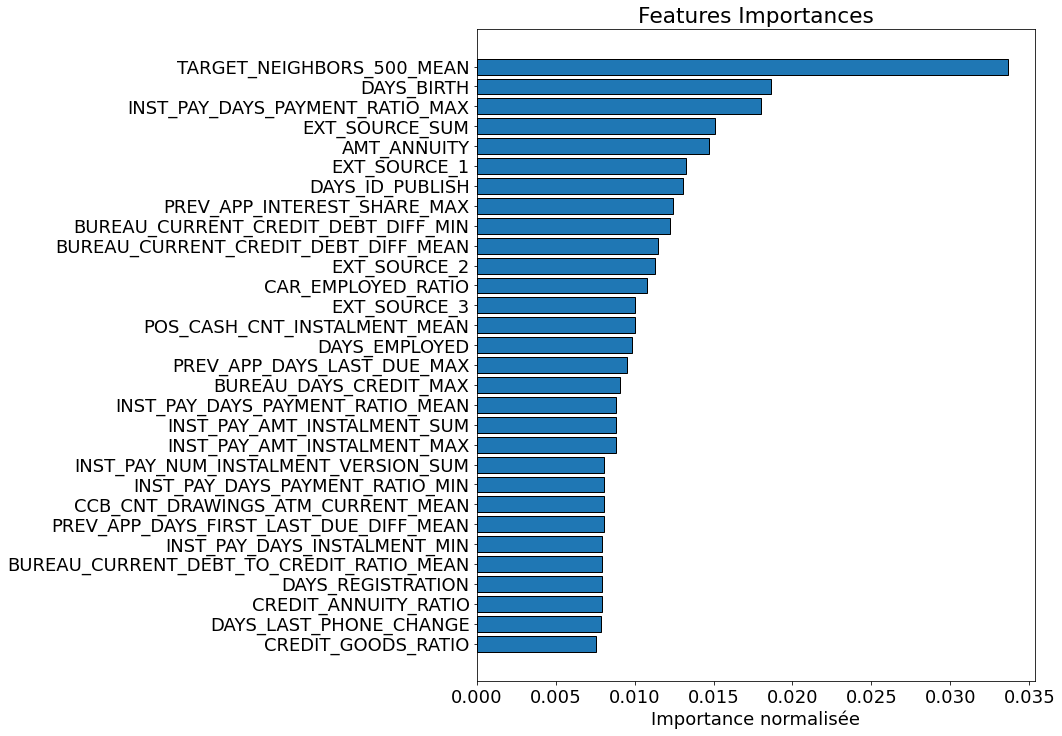

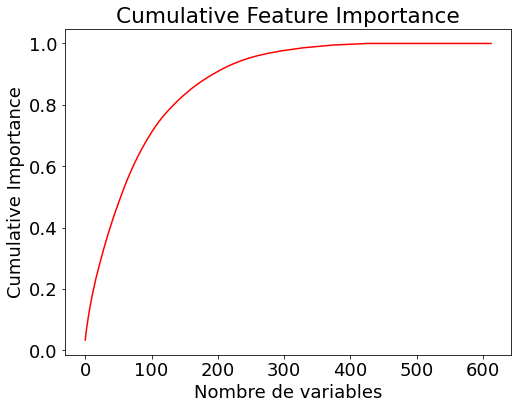

194 variables nécessaires pour 0.90 de cumulative importance


In [30]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_lightgbm_norm = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_lightgbm)

In [31]:
# Suppression des variables avec zéro importance
train_fs_lgbm = train_fs_lgbm.drop(columns=zero_features)
test_fs_lgbm = test_fs_lgbm.drop(columns=zero_features)

print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

train_fs_lgbm : (307507, 424)
test_fs_lgbm : (48744, 424)


***Second passage***

In [32]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_2, df_fs_lightgbm_2 = eda_kernel_fonctions \
    .identify_zero_importance_features(train_fs_lgbm,
                                       train_fs_lgbm_labels)

[200]	valid_0's auc: 0.797306	valid_0's binary_logloss: 0.501554
[200]	valid_0's auc: 0.791769	valid_0's binary_logloss: 0.499823

There are 21 features with 0.0 importance


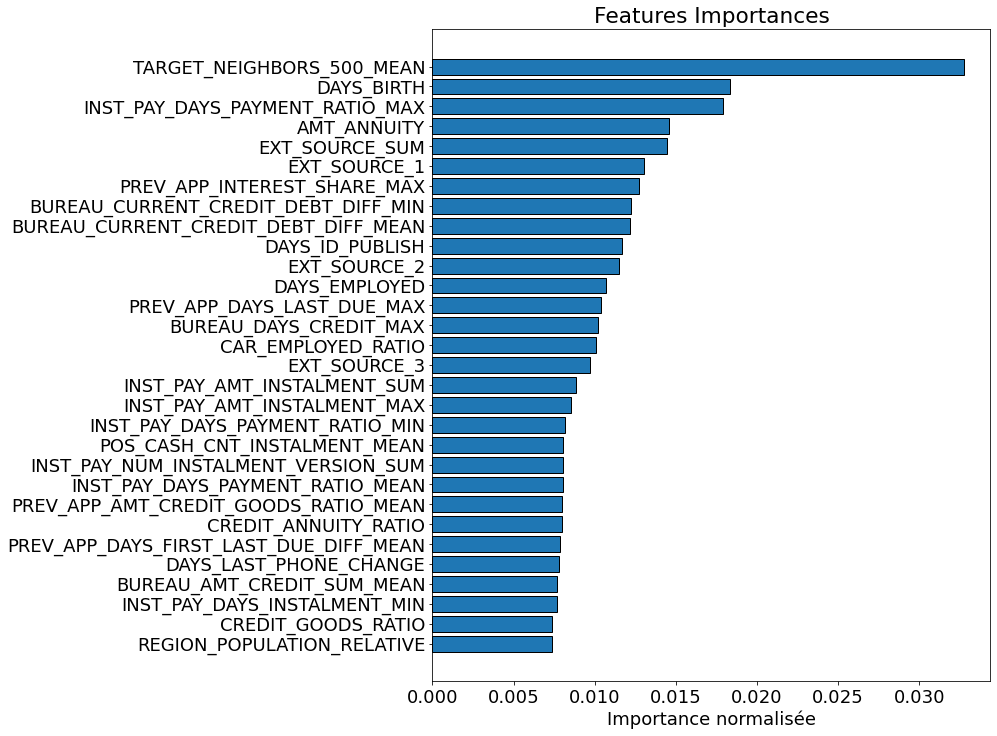

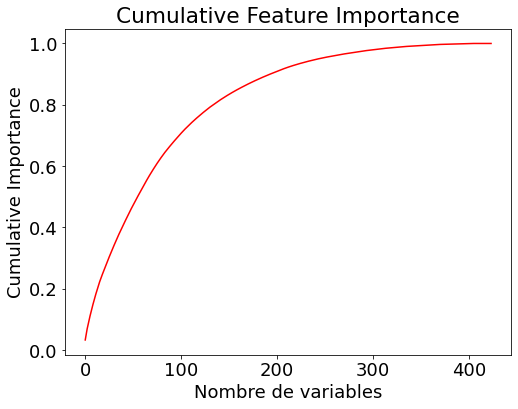

194 variables nécessaires pour 0.90 de cumulative importance


In [33]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_lightgbm_norm_2 = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_lightgbm_2)

In [34]:
# Suppression des variables avec zéro importance
train_fs_lgbm = train_fs_lgbm.drop(columns=zero_features_2)
test_fs_lgbm = test_fs_lgbm.drop(columns=zero_features_2)

print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

train_fs_lgbm : (307507, 403)
test_fs_lgbm : (48744, 403)


***Troisième passage***

In [35]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_3, df_fs_lightgbm_3 = eda_kernel_fonctions \
    .identify_zero_importance_features(train_fs_lgbm,
                                       train_fs_lgbm_labels)

[200]	valid_0's auc: 0.797701	valid_0's binary_logloss: 0.501664
[200]	valid_0's auc: 0.791846	valid_0's binary_logloss: 0.499469

There are 0 features with 0.0 importance


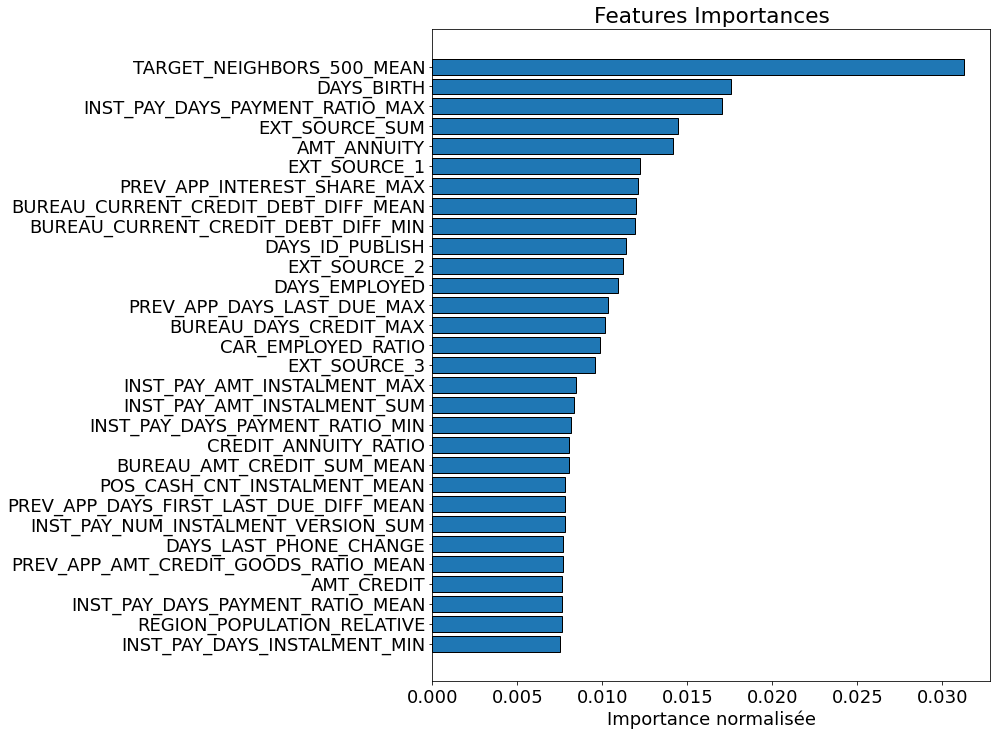

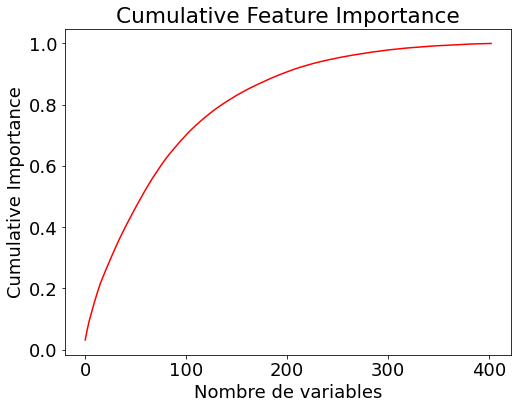

196 variables nécessaires pour 0.90 de cumulative importance


In [36]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_lightgbm_norm_3 = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_lightgbm_3)

In [37]:
# Suppression des variables avec zéro importance
train_fs_lgbm = train_fs_lgbm.drop(columns=zero_features_3)
test_fs_lgbm = test_fs_lgbm.drop(columns=zero_features_3)

print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

train_fs_lgbm : (307507, 403)
test_fs_lgbm : (48744, 403)


***Quatrième passage***

In [38]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_4, df_fs_lightgbm_4 = eda_kernel_fonctions \
    .identify_zero_importance_features(train_fs_lgbm,
                                       train_fs_lgbm_labels)

[200]	valid_0's auc: 0.797701	valid_0's binary_logloss: 0.501664
[200]	valid_0's auc: 0.791846	valid_0's binary_logloss: 0.499469

There are 0 features with 0.0 importance


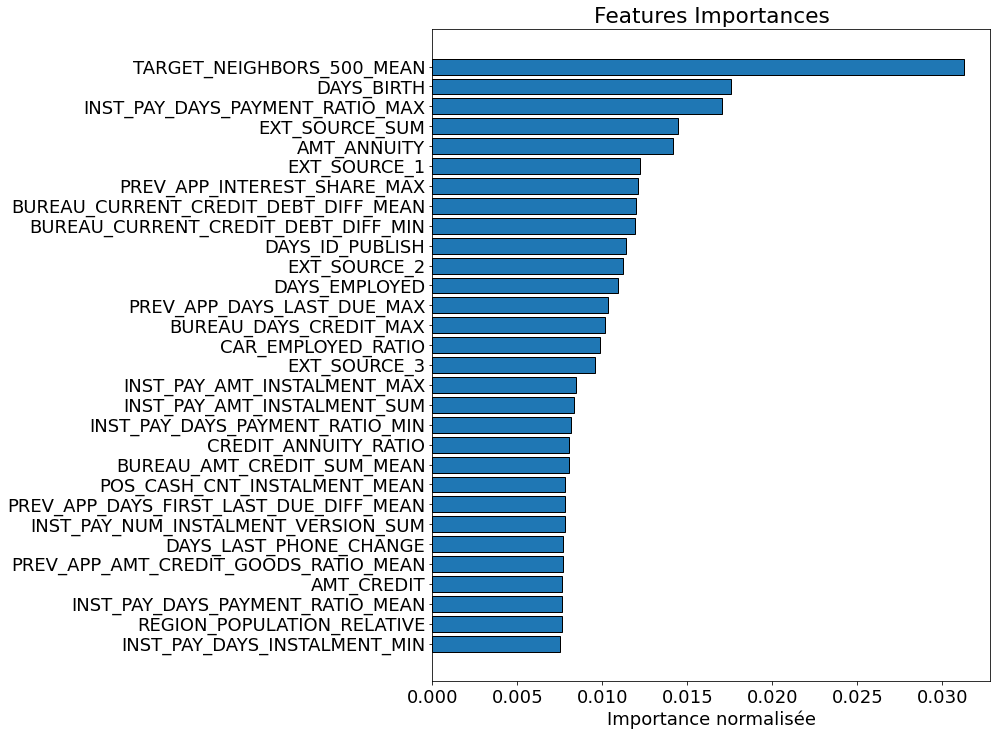

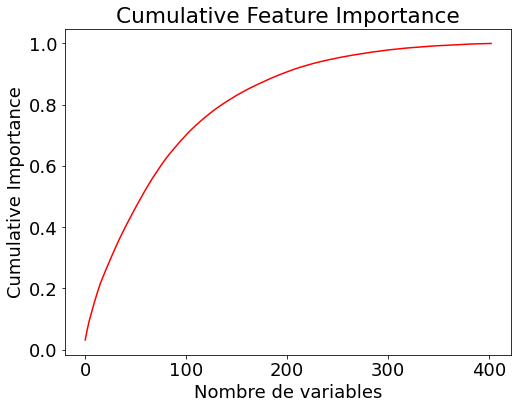

196 variables nécessaires pour 0.90 de cumulative importance


In [39]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_lightgbm_norm_4 = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_lightgbm_4)

**Reconstitution des dataframes**

In [40]:
train_fs_lgbm['TARGET'] = train_fs_lgbm_labels
train_fs_lgbm['SK_ID_CURR'] = train_fs_lgbm_ids
print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
test_fs_lgbm['SK_ID_CURR'] = test_fs_lgbm_ids
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

train_fs_lgbm : (307507, 405)
test_fs_lgbm : (48744, 404)


**Sauvegarde**

In [41]:
# Sauvegarde des features importances avec lightgbm
fic_sav_fs_lightgbm = \
    'sauvegarde/features-selection/fs_lightgbm.pickle'
with open(fic_sav_fs_lightgbm, 'wb') as f:
    pickle.dump(df_fs_lightgbm_4, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [42]:
# Chargement des features importance de ligthgbm
fic_sav_fs_train_set = \
    'sauvegarde/features-selection/fs_lightgbm.pickle'
# Chargement des features importance
with open(fic_sav_fs_train_set, 'rb') as df_fs_train_set:
    df_fs_lightgbm = pickle.load(df_fs_train_set)
df_fs_lightgbm.shape

(403, 2)

In [43]:
# Sauvegarde du nombre de features importance
df_fs_train_set = pd.DataFrame({})
df_fs_train_set = \
    outils_preprocessing.tracer_features_importance(df_fs_lightgbm,
                                                    df_fs_train_set,
                                                    'train_set',
                                                    'lightgbm')

train_set - lightgbm : 403 variables importantes conservées


**Train_imp1_set/test_imp1_set**

**Préparation des dataframes de travail**

In [44]:
# Résumé des variables qualitatives
desc_train_imp1_set = outils_data.description_variables(train_imp1_set)
desc_train_imp1_set

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,NONLIVINGAREA_AVG,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,ANNUITY_INCOME_RATIO,CREDIT_GOODS_RATIO,INCOME_GOODS_DIFF,INCOME_EXT_RATIO,CREDIT_EXT_RATIO,LAST_PHONE_EMPLOYED_RATIO,CAR_EMPLOYED_RATIO,FLAG_CONTACTS_SUM,CNT_NON_CHILDREN,EXT_SOURCE_SUM,EXT_SOURCE_MUL,EXT_SOURCE_MAX,EXT_SOURCE_VAR,INCOME_APARTMENT_AVG_MUL,OBS_DEF_30_MUL,OBS_30_CREDIT_RATIO,FLAGS_DOCUMENTS_SUM,ENQ_CREDIT_RATIO,TARGET_NEIGHBORS_500_MEAN,NAME_TYPE_SUITE_CHILDREN,NAME_TYPE_SUITE_FAMILY,NAME_TYPE_SUITE_GROUP_OF_PEOPLE,NAME_TYPE_SUITE_OTHER_A,NAME_TYPE_SUITE_OTHER_B,NAME_TYPE_SUITE_SPOUSE_PARTNER,NAME_TYPE_SUITE_UNACCOMPANIED,NAME_TYPE_SUITE_XNA,NAME_INCOME_TYPE_BUSINESSMAN,NAME_INCOME_TYPE_COMMERCIAL_ASSOCIATE,...,PREV_APP_DAYS_DECISION_MAX,PREV_APP_SELLERPLACE_AREA_MEAN,PREV_APP_SELLERPLACE_AREA_MIN,PREV_APP_CNT_PAYMENT_MEAN,PREV_APP_NAME_YIELD_GROUP_MEAN,PREV_APP_NAME_YIELD_GROUP_LAST,PREV_APP_DAYS_FIRST_DUE_SUM,PREV_APP_DAYS_LAST_DUE_MAX,PREV_APP_NFLAG_INSURED_ON_APPROVAL_SUM,PREV_APP_AMT_DECLINED_MEAN,PREV_APP_AMT_DECLINED_SUM,PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN,PREV_APP_AMT_CREDIT_GOODS_RATIO_MAX,PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN,PREV_APP_AMT_CREDIT_GOODS_DIFF_SUM,PREV_APP_AMT_CREDIT_GOODS_DIFF_MEAN,PREV_APP_AMT_CREDIT_GOODS_DIFF_MAX,PREV_APP_AMT_CREDIT_APPLICATION_RATIO_MEAN,PREV_APP_AMT_CREDIT_APPLICATION_RATIO_MIN,PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MEAN,PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MIN,PREV_APP_AMT_APPLICATION_TO_SELLERPLACE_AREA_MEAN,PREV_APP_ANNUITY_MEAN,PREV_APP_ANNUITY_GOODS_MEAN,PREV_APP_LOAN_RATE_MAX,PREV_APP_LOAN_RATE_MEAN,PREV_APP_DAYS_FIRST_LAST_DUE_DIFF_MEAN,PREV_APP_AMT_INTEREST_MEAN,PREV_APP_INTEREST_SHARE_MEAN,PREV_APP_INTEREST_SHARE_MAX,PREV_APP_INTEREST_SHARE_MIN,PREV_APP_INTEREST_RATE_MAX,PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MIN_MEAN,PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MAX_MEAN,PKPRET_BUREAU_BALANCE_STATUS_MAX_MEAN,PKPRET_BUREAU_BALANCE_STATUS_MEAN_MEAN,PKPRET_BUREAU_BALANCE_STATUS_LAST_MEAN,PKPRET_BUREAU_BALANCE_STATUS_SUM_MEAN,PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_MEAN_MEAN,PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_LAST_MEAN,BUREAU_CREDIT_ACTIVE_ACTIVE_SUM,BUREAU_CREDIT_ACTIVE_ACTIVE_COUNT,BUREAU_CREDIT_ACTIVE_ACTIVE_MEAN,BUREAU_CREDIT_ACTIVE_BAD_DEBT_SUM,BUREAU_CREDIT_ACTIVE_SOLD_SUM,BUREAU_CREDIT_ACTIVE_SOLD_MEAN,BUREAU_CREDIT_CURRENCY_CURRENCY_1_MEAN,BUREAU_CREDIT_CURRENCY_CURRENCY_2_SUM,BUREAU_CREDIT_CURRENCY_CURRENCY_3_SUM,BUREAU_CREDIT_CURRENCY_CURRENCY_3_MEAN,BUREAU_CREDIT_CURRENCY_CURRENCY_4_SUM,BUREAU_CREDIT_TYPE_ANOTHER_TYPE_OF_LOAN_SUM,BUREAU_CREDIT_TYPE_ANOTHER_TYPE_OF_LOAN_MEAN,BUREAU_CREDIT_TYPE_CAR_LOAN_SUM,BUREAU_CREDIT_TYPE_CAR_LOAN_MEAN,BUREAU_CREDIT_TYPE_CASH_LOAN_NON_EARMARKED__SUM,BUREAU_CREDIT_TYPE_CONSUMER_CREDIT_MEAN,BUREAU_CREDIT_TYPE_CREDIT_CARD_SUM,BUREAU_CREDIT_TYPE_INTERBANK_CREDIT_SUM,BUREAU_CREDIT_TYPE_L

In [45]:
# Dataframes de travail
train_imp1_fs_lgbm = train_imp1_set.copy()
print(f'train_imp1_fs_lgbm : {train_imp1_fs_lgbm.shape}')
test_imp1_fs_lgbm = test_imp1_set.copy()
print(f'test_imp1_fs_lgbm : {test_imp1_fs_lgbm.shape}')

train_imp1_fs_lgbm : (307507, 622)
test_imp1_fs_lgbm : (48744, 621)


In [46]:
# Sauvegarde des étiquettes car l'alignement supprimera
# cette variable.
train_imp1_fs_lgbm_labels = train_imp1_fs_lgbm['TARGET']

# Sauvegarde des identifiants
train_imp1_fs_lgbm_ids = train_imp1_fs_lgbm['SK_ID_CURR']
test_imp1_fs_lgbm_ids = test_imp1_fs_lgbm['SK_ID_CURR']

# Alignement des dataframes (suppression variable TARGET)
train_imp1_fs_lgbm, test_imp1_fs_lgbm = \
    train_imp1_fs_lgbm.align(test_imp1_fs_lgbm, join='inner', axis=1)

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_imp1_fs_lgbm = train_imp1_fs_lgbm.drop(columns=['SK_ID_CURR'])
test_imp1_fs_lgbm = test_imp1_fs_lgbm.drop(columns=['SK_ID_CURR'])

print(f'train_imp1_fs_lgbm : {train_imp1_fs_lgbm.shape}')
print(f'test_imp1_fs_lgbm : {test_imp1_fs_lgbm.shape}')

train_imp1_fs_lgbm : (307507, 620)
test_imp1_fs_lgbm : (48744, 620)


**Modélisation**

***Premier passage***

In [47]:
# Initialiser un tableau vide pour contenir les features importance
feature_importances_imp1 = np.zeros(train_imp1_fs_lgbm.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='goss',
                           n_estimators=10000,
                           class_weight='balanced')

In [48]:
# Entraînement du modèle deux fois pour éviter l'overfitting
for i in range(2):

    # Split en jeux d'entraînement et de validation
    train_imp1_features, valid_imp1_features, train_imp1_y, valid_imp1_y = \
        train_test_split(train_imp1_fs_lgbm, train_imp1_fs_lgbm_labels,
                         test_size=0.25, random_state=i)

    # Entraînement en utilisant early stopping
    model.fit(train_imp1_features, train_imp1_y,
              early_stopping_rounds=100,
              eval_set=[(valid_imp1_features, valid_imp1_y)],
              eval_metric='auc', verbose=200)

    # Sauvegarde des features importances
    feature_importances_imp1 += model.feature_importances_

[200]	valid_0's auc: 0.795857	valid_0's binary_logloss: 0.503251
[200]	valid_0's auc: 0.79153	valid_0's binary_logloss: 0.499962


In [49]:
# Assurez-vous de faire la moyenne des features importance !
# puisque le modèle a été entraîné 2 fois
feature_importances_imp1 = feature_importances_imp1 / 2
df_fs_imp1_lightgbm = \
    pd.DataFrame({'feature': list(train_imp1_fs_lgbm.columns),
                  'importance': feature_importances_imp1}) \
    .sort_values('importance', ascending=False)

df_fs_imp1_lightgbm.head()

,feature,importance
87,TARGET_NEIGHBORS_500_MEAN,183.5
9,DAYS_BIRTH,108.5
27,EXT_SOURCE_2,97.0
261,INST_PAY_DAYS_PAYMENT_RATIO_MAX,91.5
10,DAYS_EMPLOYED,75.5


In [50]:
# Exploration des variables avec zéro importance
# Find the features with zero importance
zero_features_imp1 = \
    list(df_fs_imp1_lightgbm[df_fs_imp1_lightgbm['importance'] == 0.0][
    'feature'])
print(f'{len(zero_features_imp1)} variables avec 0.0 importance :\n')
zero_features_imp1

182 variables avec 0.0 importance :



['BUREAU_CREDIT_CURRENCY_CURRENCY_2_SUM',
 'BUREAU_CREDIT_CURRENCY_CURRENCY_3_SUM',
 'BUREAU_CREDIT_TYPE_MOBILE_OPERATOR_LOAN_SUM',
 'BUREAU_CREDIT_TYPE_LOAN_FOR_PURCHASE_OF_SHARES_MARGIN_LENDING__SUM',
 'BUREAU_CREDIT_CURRENCY_CURRENCY_1_MEAN',
 'BUREAU_CREDIT_TYPE_LOAN_FOR_THE_PURCHASE_OF_EQUIPMENT_SUM',
 'BUREAU_CREDIT_TYPE_INTERBANK_CREDIT_SUM',
 'BUREAU_CREDIT_CURRENCY_CURRENCY_4_SUM',
 'FLAG_CONT_MOBILE',
 'BUREAU_FLAG_OVERDUE_RECENT_SUM',
 'BUREAU_CREDIT_TYPE_ANOTHER_TYPE_OF_LOAN_SUM',
 'BUREAU_CREDIT_TYPE_LOAN_FOR_BUSINESS_DEVELOPMENT_SUM',
 'FLAG_EMP_PHONE',
 'BUREAU_CREDIT_TYPE_LOAN_FOR_WORKING_CAPITAL_REPLENISHMENT_SUM',
 'FLAG_MOBIL',
 'BUREAU_CREDIT_TYPE_LOAN_FOR_THE_PURCHASE_OF_EQUIPMENT_MEAN',
 'PREV_APP_PRODUCT_COMBINATION_POS_HOUSEHOLD_WITHOUT_INTEREST_SUM',
 'BUREAU_CREDIT_TYPE_CASH_LOAN_NON_EARMARKED__SUM',
 'FLAG_DOCUMENT_2',
 'BUREAU_CURRENT_AMT_OVERDUE_DURATION_RATIO_SUM',
 'FLAG_DOCUMENT_10',
 'BUREAU_CREDIT_ACTIVE_SOLD_SUM',
 'BUREAU_CREDIT_ACTIVE_BAD_DEBT_SUM',

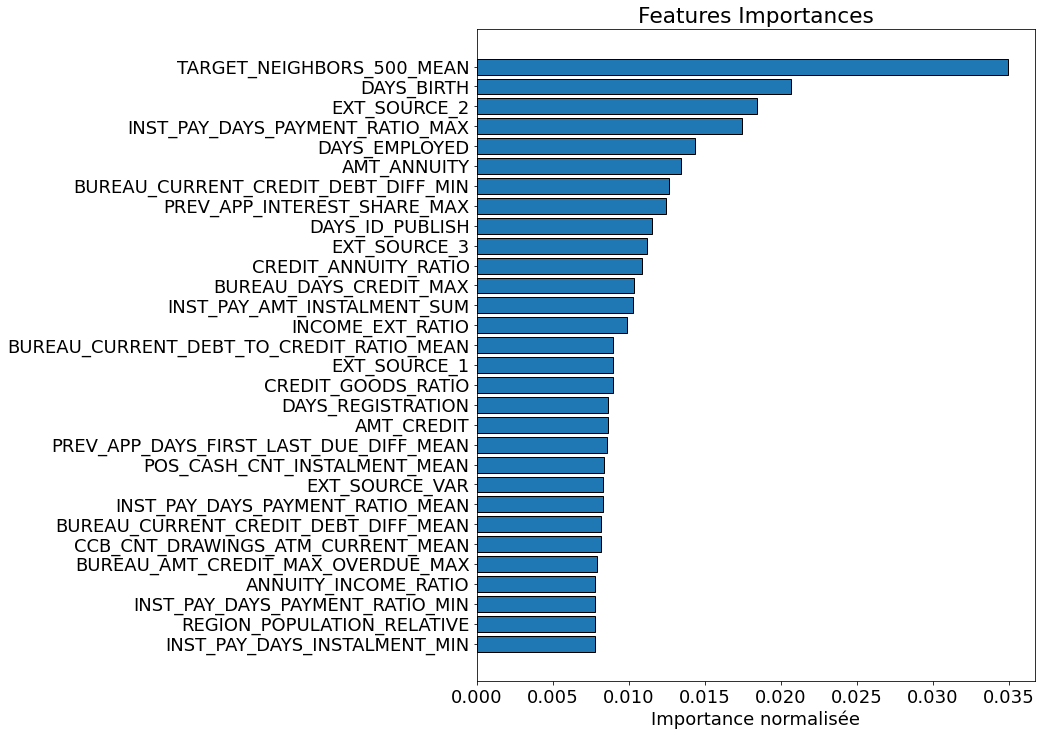

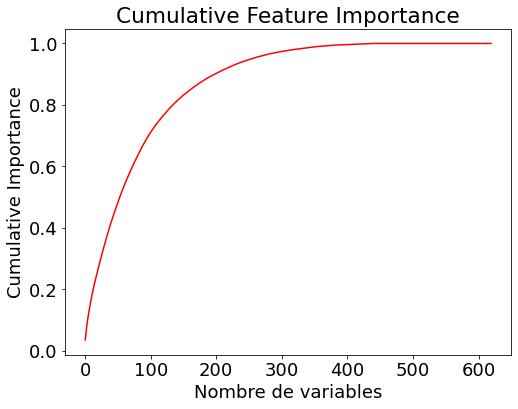

199 variables nécessaires pour 0.90 de cumulative importance


In [51]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_imp1_lightgbm_norm = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_imp1_lightgbm)

In [52]:
# Suppression des variables avec zéro importance
train_imp1_fs_lgbm = train_imp1_fs_lgbm.drop(columns=zero_features_imp1)
test_imp1_fs_lgbm = test_imp1_fs_lgbm.drop(columns=zero_features_imp1)

print(f'train_imp1_fs_lgbm : {train_imp1_fs_lgbm.shape}')
print(f'test_imp1_fs_lgbm : {test_imp1_fs_lgbm.shape}')

train_imp1_fs_lgbm : (307507, 438)
test_imp1_fs_lgbm : (48744, 438)


***Second passage***

In [53]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_imp1_2, df_fs_imp1_lightgbm_2 = eda_kernel_fonctions \
    .identify_zero_importance_features(train_imp1_fs_lgbm,
                                       train_imp1_fs_lgbm_labels)

[200]	valid_0's auc: 0.796518	valid_0's binary_logloss: 0.503217
[200]	valid_0's auc: 0.790017	valid_0's binary_logloss: 0.500404

There are 43 features with 0.0 importance


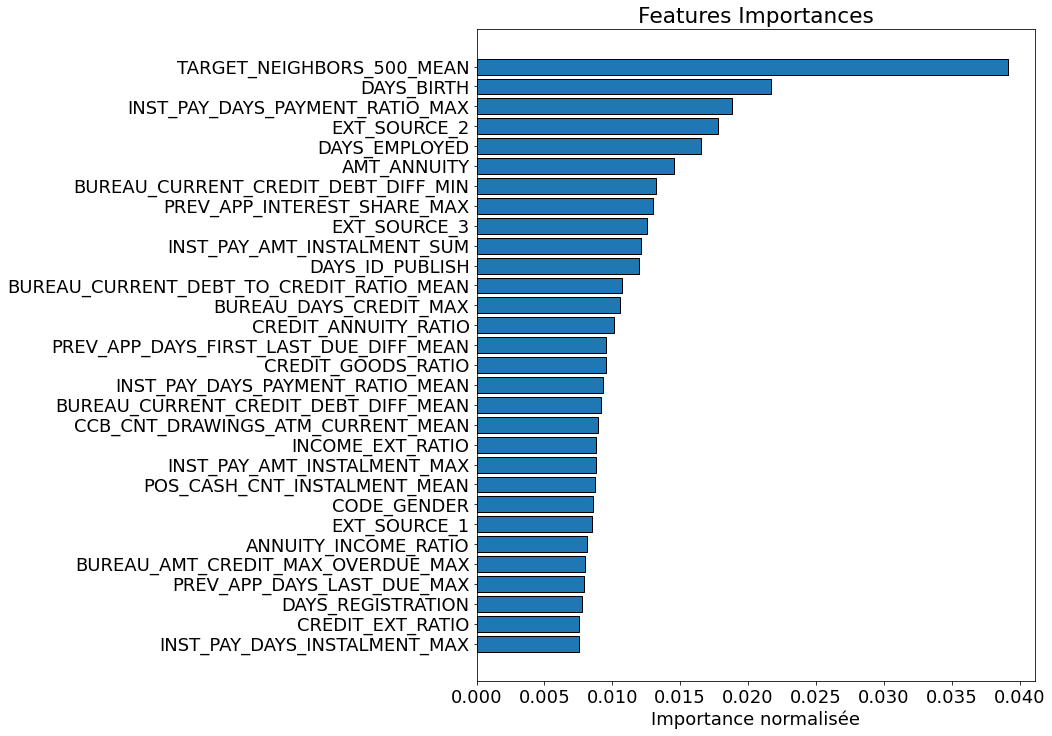

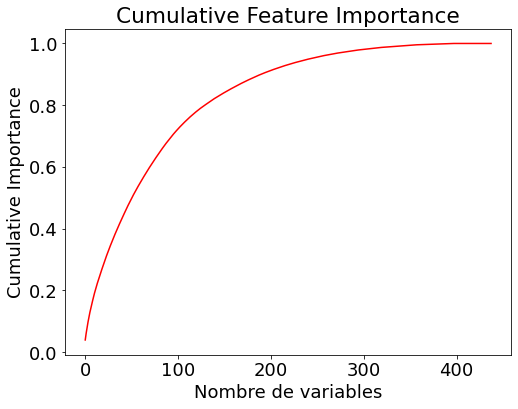

191 variables nécessaires pour 0.90 de cumulative importance


In [54]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_imp1_lightgbm_norm_2 = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_imp1_lightgbm_2)

In [55]:
# Suppression des variables avec zéro importance
train_imp1_fs_lgbm = train_imp1_fs_lgbm.drop(columns=zero_features_imp1_2)
test_imp1_fs_lgbm = test_imp1_fs_lgbm.drop(columns=zero_features_imp1_2)

print(f'train_imp1_fs_lgbm : {train_imp1_fs_lgbm.shape}')
print(f'test_imp1_fs_lgbm : {test_imp1_fs_lgbm.shape}')

train_imp1_fs_lgbm : (307507, 395)
test_imp1_fs_lgbm : (48744, 395)


***Troisième passage***

In [56]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_imp1_3, df_fs_imp1_lightgbm_3 = eda_kernel_fonctions \
    .identify_zero_importance_features(train_imp1_fs_lgbm,
                                       train_imp1_fs_lgbm_labels)

[200]	valid_0's auc: 0.796699	valid_0's binary_logloss: 0.502889
[200]	valid_0's auc: 0.790695	valid_0's binary_logloss: 0.500886

There are 0 features with 0.0 importance


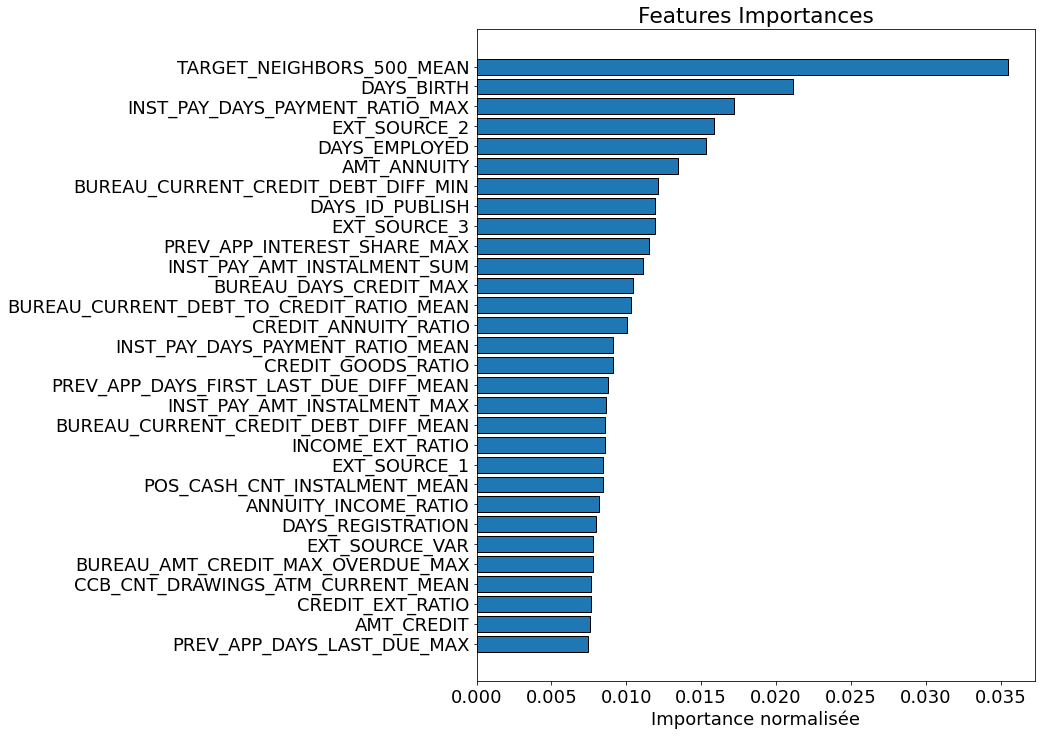

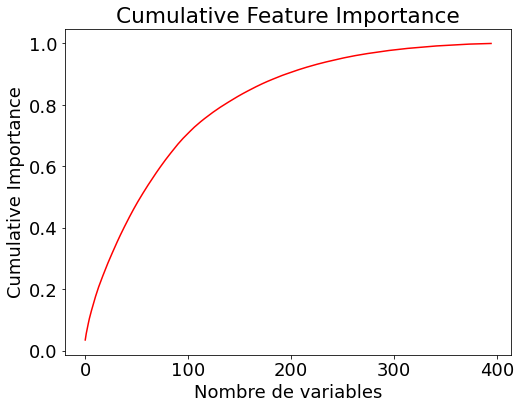

196 variables nécessaires pour 0.90 de cumulative importance


In [57]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_imp1_lightgbm_norm_3 = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_imp1_lightgbm_3)

**Reconstitution des dataframes**

In [58]:
train_imp1_fs_lgbm['TARGET'] = train_imp1_fs_lgbm_labels
train_imp1_fs_lgbm['SK_ID_CURR'] = train_imp1_fs_lgbm_ids
print(f'train_imp1_fs_lgbm : {train_imp1_fs_lgbm.shape}')
test_imp1_fs_lgbm['SK_ID_CURR'] = test_imp1_fs_lgbm_ids
print(f'test_imp1_fs_lgbm : {test_imp1_fs_lgbm.shape}')

train_imp1_fs_lgbm : (307507, 397)
test_imp1_fs_lgbm : (48744, 396)


**Sauvegarde**

In [59]:
# Sauvegarde des features importances avec lightgbm
fic_sav_fs_imp1_lightgbm = \
    'sauvegarde/features-selection/fs_imp1_lightgbm.pickle'
with open(fic_sav_fs_imp1_lightgbm, 'wb') as f:
    pickle.dump(df_fs_imp1_lightgbm_3, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [60]:
# Chargement des features importance de ligthgbm
fic_sav_fs_train_imp1_set = \
    'sauvegarde/features-selection/fs_imp1_lightgbm.pickle'
# Chargement des features importance
with open(fic_sav_fs_train_imp1_set, 'rb') as df_fs_train_imp1_set:
    df_fs_imp1_lightgbm = pickle.load(df_fs_train_imp1_set)
df_fs_imp1_lightgbm.shape

(395, 2)

In [61]:
# Sauvegarde du nombre de features importance
df_fs_train_imp1_set = pd.DataFrame({})
df_fs_train_imp1_set = \
    outils_preprocessing.tracer_features_importance(df_fs_imp1_lightgbm,
                                                    df_fs_train_imp1_set,
                                                    'train_imp1_set',
                                                    'lightgbm')

train_imp1_set - lightgbm : 395 variables importantes conservées


**Train_imp2_set/test_imp2_set**

**Préparation des dataframes de travail**

In [62]:
# Résumé des variables qualitatives
desc_train_imp2_set = outils_data.description_variables(train_imp2_set)
desc_train_imp2_set

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,NONLIVINGAREA_AVG,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,ANNUITY_INCOME_RATIO,CREDIT_GOODS_RATIO,INCOME_GOODS_DIFF,INCOME_EXT_RATIO,AGE_EMPLOYED_DIFF,LAST_PHONE_EMPLOYED_RATIO,CAR_EMPLOYED_RATIO,FLAG_CONTACTS_SUM,CNT_NON_CHILDREN,EXT_SOURCE_SUM,EXT_SOURCE_MEAN,EXT_SOURCE_VAR,OBS_DEF_30_MUL,OBS_30_CREDIT_RATIO,FLAGS_DOCUMENTS_SUM,ENQ_CREDIT_RATIO,TARGET_NEIGHBORS_500_MEAN,NAME_TYPE_SUITE_CHILDREN,NAME_TYPE_SUITE_FAMILY,NAME_TYPE_SUITE_GROUP_OF_PEOPLE,NAME_TYPE_SUITE_OTHER_A,NAME_TYPE_SUITE_OTHER_B,NAME_TYPE_SUITE_SPOUSE_PARTNER,NAME_TYPE_SUITE_UNACCOMPANIED,NAME_TYPE_SUITE_XNA,NAME_INCOME_TYPE_BUSINESSMAN,NAME_INCOME_TYPE_COMMERCIAL_ASSOCIATE,NAME_INCOME_TYPE_STATE_SERVANT,...,PREV_APP_NAME_CONTRACT_STATUS_LAST,PREV_APP_DAYS_DECISION_MEAN,PREV_APP_DAYS_DECISION_MAX,PREV_APP_SELLERPLACE_AREA_MEAN,PREV_APP_SELLERPLACE_AREA_MIN,PREV_APP_CNT_PAYMENT_MEAN,PREV_APP_NAME_YIELD_GROUP_MEAN,PREV_APP_NAME_YIELD_GROUP_LAST,PREV_APP_DAYS_FIRST_DUE_SUM,PREV_APP_DAYS_LAST_DUE_MAX,PREV_APP_NFLAG_INSURED_ON_APPROVAL_SUM,PREV_APP_AMT_DECLINED_MEAN,PREV_APP_AMT_DECLINED_SUM,PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN,PREV_APP_AMT_CREDIT_GOODS_RATIO_MAX,PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN,PREV_APP_AMT_CREDIT_GOODS_DIFF_SUM,PREV_APP_AMT_CREDIT_GOODS_DIFF_MEAN,PREV_APP_AMT_CREDIT_GOODS_DIFF_MAX,PREV_APP_AMT_CREDIT_APPLICATION_RATIO_MEAN,PREV_APP_AMT_CREDIT_APPLICATION_RATIO_MIN,PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MEAN,PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MIN,PREV_APP_AMT_APPLICATION_TO_SELLERPLACE_AREA_MEAN,PREV_APP_ANNUITY_MEAN,PREV_APP_ANNUITY_GOODS_MEAN,PREV_APP_LOAN_RATE_MAX,PREV_APP_LOAN_RATE_MEAN,PREV_APP_DAYS_FIRST_LAST_DUE_DIFF_MEAN,PREV_APP_AMT_INTEREST_MEAN,PREV_APP_INTEREST_SHARE_MEAN,PREV_APP_INTEREST_SHARE_MAX,PREV_APP_INTEREST_SHARE_MIN,PREV_APP_INTEREST_RATE_MAX,PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MIN_MEAN,PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MAX_MEAN,PKPRET_BUREAU_BALANCE_STATUS_MAX_MEAN,PKPRET_BUREAU_BALANCE_STATUS_MEAN_MEAN,PKPRET_BUREAU_BALANCE_STATUS_LAST_MEAN,PKPRET_BUREAU_BALANCE_STATUS_SUM_MEAN,PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_MEAN_MEAN,PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_LAST_MEAN,BUREAU_CREDIT_ACTIVE_ACTIVE_SUM,BUREAU_CREDIT_ACTIVE_ACTIVE_COUNT,BUREAU_CREDIT_ACTIVE_ACTIVE_MEAN,BUREAU_CREDIT_ACTIVE_BAD_DEBT_SUM,BUREAU_CREDIT_ACTIVE_SOLD_SUM,BUREAU_CREDIT_ACTIVE_SOLD_MEAN,BUREAU_CREDIT_CURRENCY_CURRENCY_1_MEAN,BUREAU_CREDIT_CURRENCY_CURRENCY_2_SUM,BUREAU_CREDIT_CURRENCY_CURRENCY_3_SUM,BUREAU_CREDIT_CURRENCY_CURRENCY_3_MEAN,BUREAU_CREDIT_CURRENCY_CURRENCY_4_SUM,BUREAU_CREDIT_TYPE_ANOTHER_TYPE_OF_LOAN_SUM,BUREAU_CREDIT_TYPE_ANOTHER_TYPE_OF_LOAN_MEAN,BUREAU_CREDIT_TYPE_CAR_LOAN_SUM,BUREAU_CREDIT_TYPE_CAR_LOAN_MEAN,BUREAU_CREDIT_TYPE_CASH_LOAN_NON_EARMARKED__SUM,BUREAU_CREDIT_TYPE_CONSUMER_CREDIT_MEAN,BUREAU_CREDIT_TYPE_

In [63]:
# Dataframes de travail
train_imp2_fs_lgbm = train_imp2_set.copy()
print(f'train_fs_lgbm : {train_imp2_fs_lgbm.shape}')
test_imp2_fs_lgbm = test_imp2_set.copy()
print(f'test_fs_lgbm : {test_imp2_fs_lgbm.shape}')

train_fs_lgbm : (307507, 617)
test_fs_lgbm : (48744, 618)


In [64]:
# Sauvegarde des étiquettes car l'alignement supprimera
# cette variable.
train_imp2_fs_lgbm_labels = train_imp2_fs_lgbm['TARGET']

# Sauvegarde des identifiants
train_imp2_fs_lgbm_ids = train_imp2_fs_lgbm['SK_ID_CURR']
test_imp2_fs_lgbm_ids = test_imp2_fs_lgbm['SK_ID_CURR']

# Alignement des dataframes (suppression variable TARGET)
train_imp2_fs_lgbm, test_im2_fs_lgbm = \
    train_imp2_fs_lgbm.align(test_imp2_fs_lgbm, join='inner', axis=1)

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_imp2_fs_lgbm = train_imp2_fs_lgbm.drop(columns=['SK_ID_CURR'])
test_imp2_fs_lgbm = test_imp2_fs_lgbm.drop(columns=['SK_ID_CURR'])

print(f'train_imp2_fs_lgbm : {train_imp2_fs_lgbm.shape}')
print(f'test_imp2_fs_lgbm : {test_imp2_fs_lgbm.shape}')

train_imp2_fs_lgbm : (307507, 615)
test_imp2_fs_lgbm : (48744, 617)


**Modélisation**

***Premier passage***

In [65]:
# Initialiser un tableau vide pour contenir les features importance
feature_importances_imp2 = np.zeros(train_imp2_fs_lgbm.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='goss',
                           n_estimators=10000,
                           class_weight='balanced')

In [66]:
# Entraînement du modèle deux fois pour éviter l'overfitting
for i in range(2):

    # Split en jeux d'entraînement et de validation
    train_imp2_features, valid_imp2_features, train_imp2_y, valid_imp2_y = \
        train_test_split(train_imp2_fs_lgbm, train_imp2_fs_lgbm_labels,
                         test_size=0.25, random_state=i)

    # Entraînement en utilisant early stopping
    model.fit(train_imp2_features, train_imp2_y,
              early_stopping_rounds=100,
              eval_set=[(valid_imp2_features, valid_imp2_y)],
              eval_metric='auc', verbose=200)

    # Sauvegarde des features importances
    feature_importances_imp2 += model.feature_importances_

[200]	valid_0's auc: 0.796321	valid_0's binary_logloss: 0.501963
[200]	valid_0's auc: 0.790604	valid_0's binary_logloss: 0.499486


In [67]:
# Assurez-vous de faire la moyenne des features importance !
# puisque le modèle a été entraîné 2 fois
feature_importances_imp2 = feature_importances_imp2 / 2
df_fs_imp2_lightgbm = \
    pd.DataFrame({'feature': list(train_imp2_fs_lgbm.columns),
                  'importance': feature_importances_imp2}) \
    .sort_values('importance', ascending=False)

df_fs_imp2_lightgbm.head()

,feature,importance
86,TARGET_NEIGHBORS_500_MEAN,147.5
80,EXT_SOURCE_MEAN,95.0
260,INST_PAY_DAYS_PAYMENT_RATIO_MAX,86.5
9,DAYS_BIRTH,79.5
7,AMT_ANNUITY,70.0


In [68]:
# Exploration des variables avec zéro importance
# Find the features with zero importance
zero_features_imp2 = \
    list(df_fs_imp2_lightgbm[df_fs_imp2_lightgbm['importance'] == 0.0][
    'feature'])
print(f'{len(zero_features_imp2)} variables avec 0.0 importance :\n')
zero_features_imp2

194 variables avec 0.0 importance :



['FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'BUREAU_CREDIT_DAY_OVERDUE_MAX',
 'BUREAU_CREDIT_TYPE_REAL_ESTATE_LOAN_MEAN',
 'BUREAU_CREDIT_TYPE_REAL_ESTATE_LOAN_SUM',
 'BUREAU_FLAG_OVERDUE_RECENT_SUM',
 'FLAG_CONT_MOBILE',
 'BUREAU_CREDIT_TYPE_UNKNOWN_TYPE_OF_LOAN_MEAN',
 'BUREAU_CREDIT_TYPE_UNKNOWN_TYPE_OF_LOAN_SUM',
 'FLAG_DOCUMENT_2',
 'REG_REGION_NOT_WORK_REGION',
 'FLAG_DOCUMENT_21',
 'BUREAU_CREDIT_TYPE_MOBILE_OPERATOR_LOAN_SUM',
 'FLAG_DOCUMENT_4',
 'BUREAU_CREDIT_ACTIVE_BAD_DEBT_SUM',
 'NAME_INCOME_TYPE_STUDENT',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'NAME_INCOME_TYPE_COMMERCIAL_ASSOCIATE',
 'NAME_INCOME_TYPE_BUSINESSMAN',
 'FLAG_DOCUMENT_12',
 'NAME_TYPE_SUITE_XNA',
 'NAME_TYPE_SUITE_SPOUSE_PARTNER',
 'NAME_TYPE_SUITE_OTHER_B',
 'NAME_TYPE_SUITE_OTHER_A',
 'NAME_TYPE_SUITE_GROUP_OF_PEOPLE',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'OCCUPATION_TYPE_COOKING_STAFF',
 'AMT_REQ_CRED

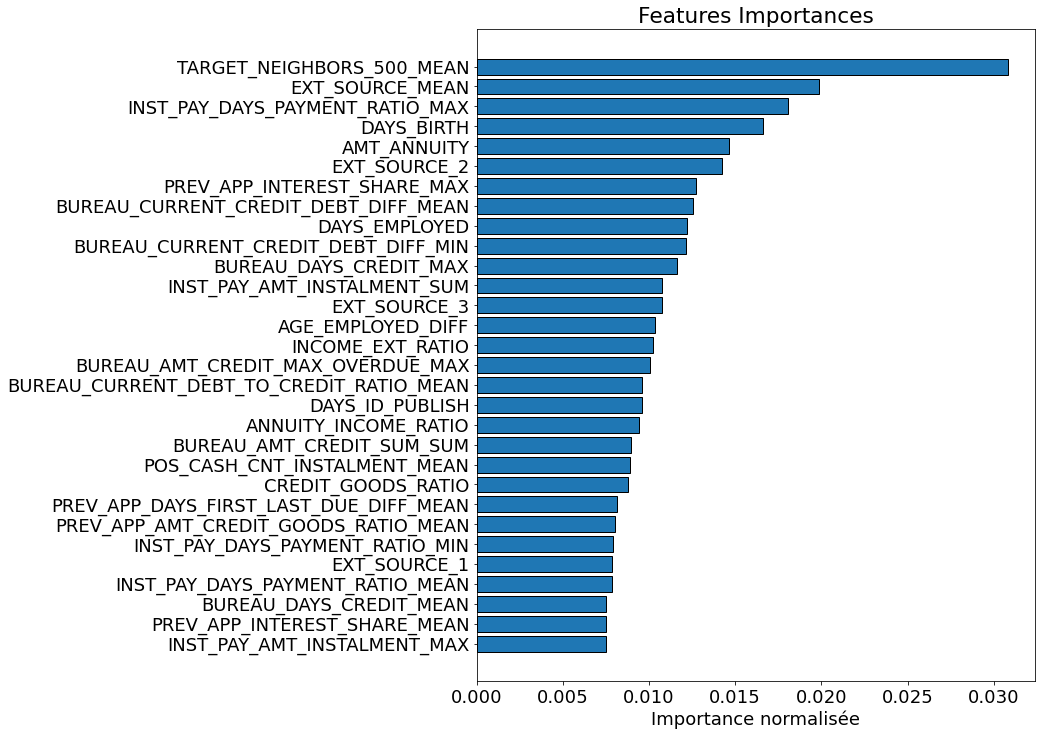

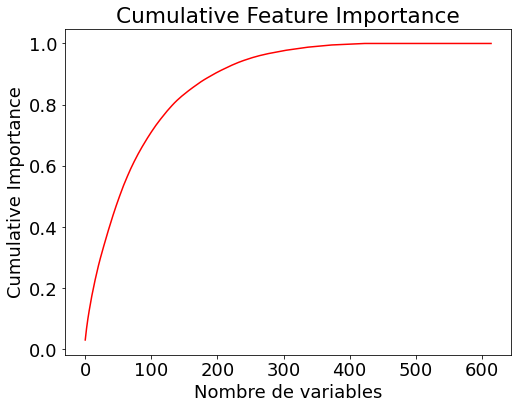

196 variables nécessaires pour 0.90 de cumulative importance


In [69]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_imp2_lightgbm_norm = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_imp2_lightgbm)

In [70]:
# Suppression des variables avec zéro importance
train_imp2_fs_lgbm = train_imp2_fs_lgbm.drop(columns=zero_features_imp2)
test_imp2_fs_lgbm = test_imp2_fs_lgbm.drop(columns=zero_features_imp2)

print(f'train_imp2_fs_lgbm : {train_imp2_fs_lgbm.shape}')
print(f'test_imp2_fs_lgbm : {test_imp2_fs_lgbm.shape}')

train_imp2_fs_lgbm : (307507, 421)
test_imp2_fs_lgbm : (48744, 423)


***Second passage***

In [71]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_imp2_2, df_fs_imp2_lightgbm_2 = eda_kernel_fonctions \
    .identify_zero_importance_features(train_imp2_fs_lgbm,
                                       train_imp2_fs_lgbm_labels)

[200]	valid_0's auc: 0.795749	valid_0's binary_logloss: 0.5028
[200]	valid_0's auc: 0.791126	valid_0's binary_logloss: 0.499636

There are 26 features with 0.0 importance


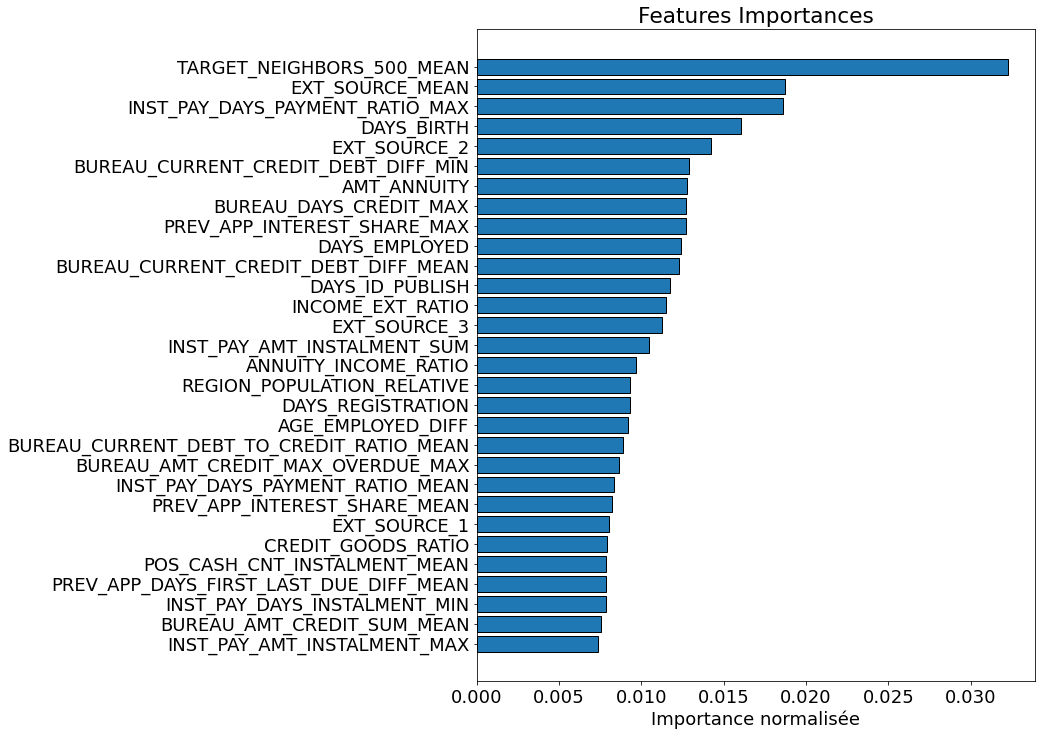

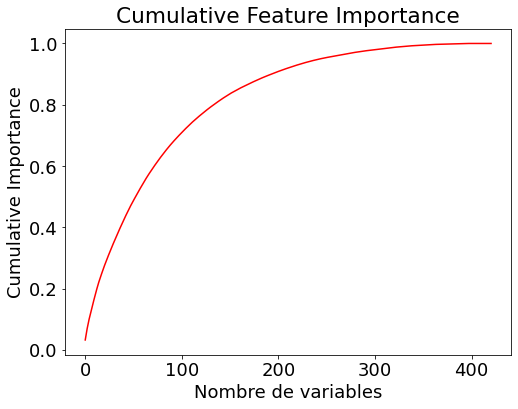

194 variables nécessaires pour 0.90 de cumulative importance


In [72]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_imp2_lightgbm_norm_2 = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_imp2_lightgbm_2)

In [73]:
# Suppression des variables avec zéro importance
train_imp2_fs_lgbm = train_imp2_fs_lgbm.drop(columns=zero_features_imp2_2)
test_imp2_fs_lgbm = test_imp2_fs_lgbm.drop(columns=zero_features_imp2_2)

print(f'train_imp2_fs_lgbm : {train_imp2_fs_lgbm.shape}')
print(f'test_imp2_fs_lgbm : {test_imp2_fs_lgbm.shape}')

train_imp2_fs_lgbm : (307507, 395)
test_imp2_fs_lgbm : (48744, 397)


***Troisième passage***

In [74]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_imp2_3, df_fs_imp2_lightgbm_3 = eda_kernel_fonctions \
    .identify_zero_importance_features(train_imp2_fs_lgbm,
                                       train_imp2_fs_lgbm_labels)

[200]	valid_0's auc: 0.796179	valid_0's binary_logloss: 0.502862
[200]	valid_0's auc: 0.791615	valid_0's binary_logloss: 0.499203

There are 0 features with 0.0 importance


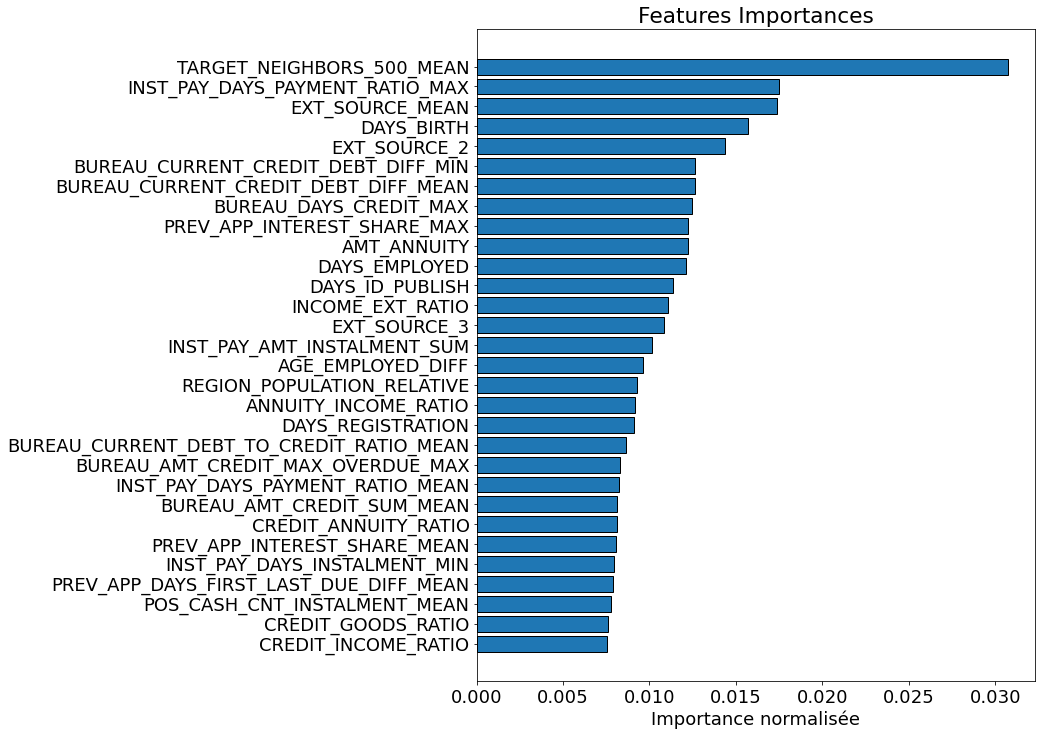

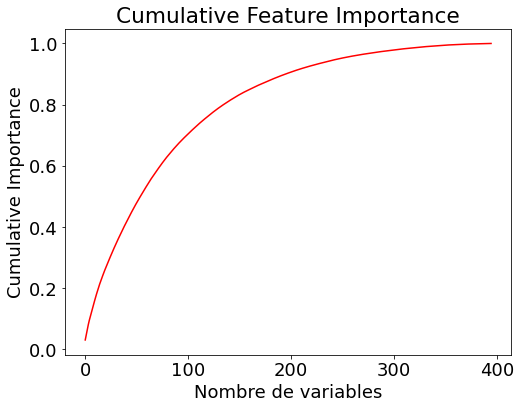

196 variables nécessaires pour 0.90 de cumulative importance


In [75]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_imp2_lightgbm_norm_3 = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_imp2_lightgbm_3)

**Reconstitution des dataframes**

In [76]:
train_imp2_fs_lgbm['TARGET'] = train_imp2_fs_lgbm_labels
train_imp2_fs_lgbm['SK_ID_CURR'] = train_imp2_fs_lgbm_ids
print(f'train_imp2_fs_lgbm : {train_imp2_fs_lgbm.shape}')
test_imp2_fs_lgbm['SK_ID_CURR'] = test_imp2_fs_lgbm_ids
print(f'test_imp2_fs_lgbm : {test_imp2_fs_lgbm.shape}')

train_imp2_fs_lgbm : (307507, 397)
test_imp2_fs_lgbm : (48744, 398)


**Sauvegarde**

In [77]:
# Sauvegarde des features importances avec lightgbm
fic_sav_fs_imp2_lightgbm = \
    'sauvegarde/features-selection/fs_imp2_lightgbm.pickle'
with open(fic_sav_fs_imp2_lightgbm, 'wb') as f:
    pickle.dump(df_fs_imp2_lightgbm_3, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [78]:
# Chargement des features importance de ligthgbm
fic_sav_fs_train_imp2_set = \
    'sauvegarde/features-selection/fs_imp2_lightgbm.pickle'
# Chargement des features importance
with open(fic_sav_fs_train_imp2_set, 'rb') as df_fs_train_imp2_set:
    df_fs_imp2_lightgbm = pickle.load(df_fs_train_imp2_set)
df_fs_imp2_lightgbm.shape

(395, 2)

In [79]:
# Sauvegarde du nombre de features importance
df_fs_train_imp2_set = pd.DataFrame({})
df_fs_train_imp2_set = \
    outils_preprocessing.tracer_features_importance(df_fs_imp2_lightgbm,
                                                    df_fs_train_imp2_set,
                                                    'train_imp2_set',
                                                    'lightgbm')

train_imp2_set - lightgbm : 395 variables importantes conservées


### Bilan - Jeux de données finaux

**Train_set/test_set**

**Avec la variable magique TARGET_NEIGHBORS_500_MEAN**

**Répétitions des variables conservées**

In [97]:
# Récupération des variables conservées pour chaque feature selection
liste_var = df_fs_lightgbm['feature'].to_list()
print(len(liste_var))


403


In [98]:
# Nomre de répétitions de chacune des variables
dico_nbre_repet_var = Counter(liste_var)
len(dico_nbre_repet_var)

403

In [99]:

df_nbr_repet_var = pd.DataFrame.from_dict(dico_nbre_repet_var,
                                          orient='index',
                                          columns=['Nbr_repetition'])\
    .reset_index().rename(columns={'index':'Variables'}) \
    .sort_values(by='Nbr_repetition', ascending=False)

df_nbr_repet_var.style.hide_index()

Variables,Nbr_repetition
TARGET_NEIGHBORS_500_MEAN,1
PREV_APP_NAME_SELLER_INDUSTRY_INDUSTRY_MEAN,1
ORGANIZATION_TYPE_REALTOR,1
PREV_APP_NAME_GOODS_CATEGORY_CONSTRUCTION_MATERIALS_MEAN,1
CCB_NAME_CONTRACT_STATUS_COMPLETED_SUM,1
PREV_APP_WEEKDAY_APPR_PROCESS_START_SATURDAY_SUM,1
CCB_CNT_INSTALMENT_MATURE_CUM_MIN,1
FLAG_CONTACTS_SUM,1
CCB_AMT_INTEREST_RECEIVABLE_MIN,1
FLAG_DOCUMENT_3,1


In [100]:
# Plage de nombre de répétitions
liste_bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
outils_data.distribution_variables_plages(df_nbr_repet_var,
                                          'Nbr_repetition',
                                          liste_bins)

Plage,nb_données,%_données
"(0, 1]",403,100.000000
"(1, 2]",0,0.000000
"(2, 3]",0,0.000000
"(3, 4]",0,0.000000
"(4, 5]",0,0.000000
"(5, 6]",0,0.000000
"(6, 7]",0,0.000000
"(7, 8]",0,0.000000


In [102]:
# Les variables présentes plus de 6 fois pour les 8 méthodes de feature
#  sélection seront conservées
var_cons_train_set = \
    df_nbr_repet_var[df_nbr_repet_var['Nbr_repetition'] > 0][
        'Variables'].to_list()
print(f'{len(var_cons_train_set)} variables conservées pour le train_set')
var_cons_train_set

403 variables conservées pour le train_set


['TARGET_NEIGHBORS_500_MEAN',
 'PREV_APP_NAME_SELLER_INDUSTRY_INDUSTRY_MEAN',
 'ORGANIZATION_TYPE_REALTOR',
 'PREV_APP_NAME_GOODS_CATEGORY_CONSTRUCTION_MATERIALS_MEAN',
 'CCB_NAME_CONTRACT_STATUS_COMPLETED_SUM',
 'PREV_APP_WEEKDAY_APPR_PROCESS_START_SATURDAY_SUM',
 'CCB_CNT_INSTALMENT_MATURE_CUM_MIN',
 'FLAG_CONTACTS_SUM',
 'CCB_AMT_INTEREST_RECEIVABLE_MIN',
 'FLAG_DOCUMENT_3',
 'POS_CASH_CNT_INSTALMENT_FUTURE_MIN',
 'PREV_APP_PRODUCT_COMBINATION_POS_OTHER_WITH_INTEREST_MEAN',
 'PREV_APP_CHANNEL_TYPE_COUNTRY_WIDE_SUM',
 'CNT_CHILDREN',
 'NAME_HOUSING_TYPE_MUNICIPAL_APARTMENT',
 'PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITHOUT_INTEREST_SUM',
 'FLAG_PHONE',
 'NAME_HOUSING_TYPE_OFFICE_APARTMENT',
 'ORGANIZATION_TYPE_SCHOOL',
 'CCB_CNT_DRAWINGS_ATM_CURRENT_MAX',
 'BUREAU_CREDIT_TYPE_MICROLOAN_SUM',
 'OCCUPATION_TYPE_ACCOUNTANTS',
 'PREV_APP_NAME_TYPE_SUITE_SPOUSE_PARTNER_SUM',
 'CCB_BALANCE_LIMIT_RATIO_MIN',
 'PREV_APP_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_SUM',
 'AMT_REQ_CREDIT_BUREAU_YE

In [103]:
# Sauvegarde des variables conservées pour le train_set
fic_sav_var_cons_train_set = \
    'sauvegarde/features-selection/var_cons_train_set.pickle'
with open(fic_sav_var_cons_train_set, 'wb') as f:
    pickle.dump(var_cons_train_set, f, pickle.HIGHEST_PROTOCOL)

In [104]:
# Chargement des variables conservées pour le train_set
fic_sav_var_cons_train_set = \
    'sauvegarde/features-selection/var_cons_train_set.pickle'
with open(fic_sav_var_cons_train_set, 'rb') as df_var_cons_train_set:
    var_cons_train_set = pickle.load(df_var_cons_train_set)
len(var_cons_train_set)

403

**Test en ne conservant que les variables les plus sélectionnées par feature selection**

In [105]:
# Les variables présentes plus de 6 fois pour les 8 méthodes de feature
#  sélection seront conservées
var_cons_train_set_small = \
    df_nbr_repet_var[df_nbr_repet_var['Nbr_repetition'] > 0][
        'Variables'].to_list()
print(f'{len(var_cons_train_set_small)} variables conservées pour le train_set')
var_cons_train_set_small

403 variables conservées pour le train_set


['TARGET_NEIGHBORS_500_MEAN',
 'PREV_APP_NAME_SELLER_INDUSTRY_INDUSTRY_MEAN',
 'ORGANIZATION_TYPE_REALTOR',
 'PREV_APP_NAME_GOODS_CATEGORY_CONSTRUCTION_MATERIALS_MEAN',
 'CCB_NAME_CONTRACT_STATUS_COMPLETED_SUM',
 'PREV_APP_WEEKDAY_APPR_PROCESS_START_SATURDAY_SUM',
 'CCB_CNT_INSTALMENT_MATURE_CUM_MIN',
 'FLAG_CONTACTS_SUM',
 'CCB_AMT_INTEREST_RECEIVABLE_MIN',
 'FLAG_DOCUMENT_3',
 'POS_CASH_CNT_INSTALMENT_FUTURE_MIN',
 'PREV_APP_PRODUCT_COMBINATION_POS_OTHER_WITH_INTEREST_MEAN',
 'PREV_APP_CHANNEL_TYPE_COUNTRY_WIDE_SUM',
 'CNT_CHILDREN',
 'NAME_HOUSING_TYPE_MUNICIPAL_APARTMENT',
 'PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITHOUT_INTEREST_SUM',
 'FLAG_PHONE',
 'NAME_HOUSING_TYPE_OFFICE_APARTMENT',
 'ORGANIZATION_TYPE_SCHOOL',
 'CCB_CNT_DRAWINGS_ATM_CURRENT_MAX',
 'BUREAU_CREDIT_TYPE_MICROLOAN_SUM',
 'OCCUPATION_TYPE_ACCOUNTANTS',
 'PREV_APP_NAME_TYPE_SUITE_SPOUSE_PARTNER_SUM',
 'CCB_BALANCE_LIMIT_RATIO_MIN',
 'PREV_APP_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_SUM',
 'AMT_REQ_CREDIT_BUREAU_YE

In [106]:
# Sauvegarde des variables conservées pour le train_set réduit
fic_sav_var_cons_train_set_small = \
    'sauvegarde/features-selection/var_cons_train_set_small.pickle'
with open(fic_sav_var_cons_train_set_small, 'wb') as f:
    pickle.dump(var_cons_train_set_small, f, pickle.HIGHEST_PROTOCOL)

In [107]:
# Chargement des variables conservées pour le train_set réduit
fic_sav_var_cons_train_set_small = \
    'sauvegarde/features-selection/var_cons_train_set_small.pickle'
with open(fic_sav_var_cons_train_set_small, 'rb') as df_var_cons_train_set_small:
    var_cons_train_set_small = pickle.load(df_var_cons_train_set_small)
len(var_cons_train_set_small)

403

**Constitution des dataframes train_set et test_set finaux**

In [108]:
# Constitution du train_set
print(f'{train_set.shape}')
# Ajout de l'identifiant du client et de la variable cible
var_cons_train_set_avec_target_id = ['SK_ID_CURR', 'TARGET']
var_cons_train_set_avec_target_id.extend(var_cons_train_set)
train_set = train_set[var_cons_train_set_avec_target_id]
print(f'{train_set.shape}')

(307507, 615)
(307507, 405)


In [109]:
# Constitution du test_set
print(f'{test_set.shape}')
# Ajout de l'identifiant du client
var_cons_train_set_avec_id = ['SK_ID_CURR']
var_cons_train_set_avec_id.extend(var_cons_train_set)
test_set = test_set[var_cons_train_set_avec_id]
print(f'{test_set.shape}')

(48744, 614)
(48744, 404)


In [110]:
# Constitution du train_set réduit
train_set_small = train_set.copy()
print(f'{train_set_small.shape}')
# Ajout de l'identifiant du client et de la variable cible
var_cons_train_set_small_avec_target_id = ['SK_ID_CURR', 'TARGET']
var_cons_train_set_small_avec_target_id.extend(var_cons_train_set_small)
train_set_small = train_set_small[var_cons_train_set_small_avec_target_id]
print(f'{train_set_small.shape}')

(307507, 405)
(307507, 405)


In [111]:
# Constitution du test_set réduit
test_set_small = test_set.copy()
print(f'{test_set_small.shape}')
# Ajout de l'identifiant du client
var_cons_train_set_small_avec_id = ['SK_ID_CURR']
var_cons_train_set_small_avec_id.extend(var_cons_train_set_small)
test_set_small = test_set_small[var_cons_train_set_small_avec_id]
print(f'{test_set_small.shape}')

(48744, 404)
(48744, 404)


**Sauvegarde**

In [112]:
# Sauvegarde du train_set après nettoyage, feature engineering et
# feature selection
fic_sav_train_set = \
    'sauvegarde/features-selection/train_set.pickle'
with open(fic_sav_train_set, 'wb') as f:
    pickle.dump(train_set, f, pickle.HIGHEST_PROTOCOL)

In [113]:
# Export en fichier .csv
train_set.to_csv('train_set.csv', index=False)

In [114]:
# Sauvegarde du test_set après nettoyage, feature engineering et
# feature selection
fic_sav_test_set = \
    'sauvegarde/features-selection/test_set.pickle'
with open(fic_sav_test_set, 'wb') as f:
    pickle.dump(test_set, f, pickle.HIGHEST_PROTOCOL)

In [115]:
# Export en fichier .csv
test_set.to_csv('test_set.csv', index=False)

In [116]:
# Sauvegarde du train_set réduit après nettoyage, feature engineering et
# feature selection
fic_sav_train_set_small = \
    'sauvegarde/features-selection/train_set_small.pickle'
with open(fic_sav_train_set_small, 'wb') as f:
    pickle.dump(train_set_small, f, pickle.HIGHEST_PROTOCOL)

In [117]:
# Export en fichier .csv
train_set_small.to_csv('train_set_small.csv', index=False)

In [118]:
# Sauvegarde du test_set réduit après nettoyage, feature engineering et
# feature selection
fic_sav_test_set_small = \
    'sauvegarde/features-selection/test_set_small.pickle'
with open(fic_sav_test_set_small, 'wb') as f:
    pickle.dump(test_set_small, f, pickle.HIGHEST_PROTOCOL)

In [119]:
# Export en fichier .csv
test_set_small.to_csv('test_set_small.csv', index=False)

**Chargement**

In [120]:
# Chargement du train_set
fic_sav_train_set_small = \
    'sauvegarde/features-selection/train_set_small.pickle'
with open(fic_sav_train_set_small, 'rb') as df_train_set_small:
    train_set_small = pickle.load(df_train_set_small)
train_set_small.shape

(307507, 405)

In [121]:
# Chargement du test_set
fic_sav_test_set_small = \
    'sauvegarde/features-selection/test_set_small.pickle'
with open(fic_sav_test_set_small, 'rb') as df_test_set_small:
    test_set_small = pickle.load(df_test_set_small)
test_set_small.shape

(48744, 404)

**Sans la variable magique TARGET_NEIGHBORS_500_MEAN**

**Répétitions des variables conservées**

In [122]:
# Récupération des variables conservées pour chaque feature selection
liste_var_sans = df_fs_sans_lightgbm['feature'].to_list()
print(len(liste_var_sans))

398


In [123]:
# Nomre de répétitions de chacune des variables
dico_nbre_repet_var_sans = Counter(liste_var_sans)
len(dico_nbre_repet_var_sans)

398

In [124]:

df_nbr_repet_var_sans = pd.DataFrame.from_dict(dico_nbre_repet_var_sans,
                                               orient='index',
                                               columns=['Nbr_repetition'])\
    .reset_index().rename(columns={'index':'Variables'}) \
    .sort_values(by='Nbr_repetition', ascending=False)

df_nbr_repet_var_sans.style.hide_index()

Variables,Nbr_repetition
CREDIT_ANNUITY_RATIO,1
PREV_APP_NAME_CASH_LOAN_PURPOSE_URGENT_NEEDS_MEAN,1
PREV_APP_NAME_CASH_LOAN_PURPOSE_OTHER_MEAN,1
PREV_APP_PRODUCT_COMBINATION_POS_OTHER_WITH_INTEREST_MEAN,1
POS_CASH_NAME_CONTRACT_STATUS_SIGNED_SUM,1
PREV_APP_PRODUCT_COMBINATION_POS_MOBILE_WITHOUT_INTEREST_MEAN,1
POS_CASH_NAME_CONTRACT_STATUS_COMPLETED_SUM,1
CNT_CHILDREN,1
FLAG_DOCUMENT_8,1
PREV_APP_NAME_CASH_LOAN_PURPOSE_REPAIRS_MEAN,1


In [125]:
# Plage de nombre de répétitions
liste_bins = [0, 1, 2, 3, 4, 5, 6]
outils_data.distribution_variables_plages(df_nbr_repet_var_sans,
                                          'Nbr_repetition',
                                          liste_bins)

Plage,nb_données,%_données
"(0, 1]",398,100.000000
"(1, 2]",0,0.000000
"(2, 3]",0,0.000000
"(3, 4]",0,0.000000
"(4, 5]",0,0.000000
"(5, 6]",0,0.000000


In [126]:
# Les variables présentes plus de 6 fois pour les 6 méthodes de feature
#  sélection seront conservées
var_cons_train_set_sans = \
    df_nbr_repet_var_sans[df_nbr_repet_var_sans['Nbr_repetition'] > 0][
        'Variables'].to_list()
dim_var = len(var_cons_train_set_sans)
print(f'{dim_var} variables conservées pour le train_set')
var_cons_train_set_sans

398 variables conservées pour le train_set


['CREDIT_ANNUITY_RATIO',
 'PREV_APP_NAME_CASH_LOAN_PURPOSE_URGENT_NEEDS_MEAN',
 'PREV_APP_NAME_CASH_LOAN_PURPOSE_OTHER_MEAN',
 'PREV_APP_PRODUCT_COMBINATION_POS_OTHER_WITH_INTEREST_MEAN',
 'POS_CASH_NAME_CONTRACT_STATUS_SIGNED_SUM',
 'PREV_APP_PRODUCT_COMBINATION_POS_MOBILE_WITHOUT_INTEREST_MEAN',
 'POS_CASH_NAME_CONTRACT_STATUS_COMPLETED_SUM',
 'CNT_CHILDREN',
 'FLAG_DOCUMENT_8',
 'PREV_APP_NAME_CASH_LOAN_PURPOSE_REPAIRS_MEAN',
 'OCCUPATION_TYPE_SALES_STAFF',
 'ORGANIZATION_TYPE_GOVERNMENT',
 'ORGANIZATION_TYPE_TRANSPORT_TYPE_3',
 'POS_CASH_CNT_INSTALMENT_FUTURE_MIN',
 'CCB_AMT_PAYMENT_CURRENT_MIN',
 'CCB_BALANCE_LIMIT_RATIO_MIN',
 'OCCUPATION_TYPE_MEDICINE_STAFF',
 'PREV_APP_NAME_GOODS_CATEGORY_COMPUTERS_SUM',
 'PREV_APP_WEEKDAY_APPR_PROCESS_START_THURSDAY_SUM',
 'PREV_APP_PRODUCT_COMBINATION_CASH_STREET_MIDDLE_MEAN',
 'PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITHOUT_INTEREST_MEAN',
 'PREV_APP_NAME_GOODS_CATEGORY_JEWELRY_MEAN',
 'PREV_APP_NFLAG_INSURED_ON_APPROVAL_SUM',
 'PREV_APP_

In [127]:
# Sauvegarde des variables conservées pour le train_set sans var magique
fic_sav_var_cons_train_set_sans = \
    'sauvegarde/features-selection/var_cons_train_set_sans.pickle'
with open(fic_sav_var_cons_train_set_sans, 'wb') as f:
    pickle.dump(var_cons_train_set_sans, f, pickle.HIGHEST_PROTOCOL)

In [128]:
# Chargement des variables conservées pour le train_set sans var magique
fic_sav_var_cons_train_set_sans = \
    'sauvegarde/features-selection/var_cons_train_set_sans.pickle'
with open(fic_sav_var_cons_train_set_sans, 'rb') as df_var_cons_train_set_sans:
    var_cons_train_set_sans = pickle.load(df_var_cons_train_set_sans)
len(var_cons_train_set_sans)

398

**Test avec les variables les plus sélectionnées par le feature selection**

In [129]:
# Les variables les plus présentes pour les 6 méthodes de feature
#  sélection seront conservées
var_cons_train_set_sans_small = \
    df_nbr_repet_var_sans[df_nbr_repet_var_sans['Nbr_repetition'] > 0][
        'Variables'].to_list()
dim_var_small = len(var_cons_train_set_sans_small)
print(f'{dim_var_small} variables conservées pour le train_set')
var_cons_train_set_sans_small

398 variables conservées pour le train_set


['CREDIT_ANNUITY_RATIO',
 'PREV_APP_NAME_CASH_LOAN_PURPOSE_URGENT_NEEDS_MEAN',
 'PREV_APP_NAME_CASH_LOAN_PURPOSE_OTHER_MEAN',
 'PREV_APP_PRODUCT_COMBINATION_POS_OTHER_WITH_INTEREST_MEAN',
 'POS_CASH_NAME_CONTRACT_STATUS_SIGNED_SUM',
 'PREV_APP_PRODUCT_COMBINATION_POS_MOBILE_WITHOUT_INTEREST_MEAN',
 'POS_CASH_NAME_CONTRACT_STATUS_COMPLETED_SUM',
 'CNT_CHILDREN',
 'FLAG_DOCUMENT_8',
 'PREV_APP_NAME_CASH_LOAN_PURPOSE_REPAIRS_MEAN',
 'OCCUPATION_TYPE_SALES_STAFF',
 'ORGANIZATION_TYPE_GOVERNMENT',
 'ORGANIZATION_TYPE_TRANSPORT_TYPE_3',
 'POS_CASH_CNT_INSTALMENT_FUTURE_MIN',
 'CCB_AMT_PAYMENT_CURRENT_MIN',
 'CCB_BALANCE_LIMIT_RATIO_MIN',
 'OCCUPATION_TYPE_MEDICINE_STAFF',
 'PREV_APP_NAME_GOODS_CATEGORY_COMPUTERS_SUM',
 'PREV_APP_WEEKDAY_APPR_PROCESS_START_THURSDAY_SUM',
 'PREV_APP_PRODUCT_COMBINATION_CASH_STREET_MIDDLE_MEAN',
 'PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITHOUT_INTEREST_MEAN',
 'PREV_APP_NAME_GOODS_CATEGORY_JEWELRY_MEAN',
 'PREV_APP_NFLAG_INSURED_ON_APPROVAL_SUM',
 'PREV_APP_

In [130]:
# Sauvegarde des variables conservées pour le train_set sans var magique
fic_sav_var_cons_train_set_sans_small = \
    'sauvegarde/features-selection/var_cons_train_set_sans_small.pickle'
with open(fic_sav_var_cons_train_set_sans_small, 'wb') as f:
    pickle.dump(var_cons_train_set_sans_small, f, pickle.HIGHEST_PROTOCOL)

In [131]:
# Chargement des variables conservées pour le train_set sans var magique
fic_sav_var_cons_train_set_sans_small = \
    'sauvegarde/features-selection/var_cons_train_set_sans_small.pickle'
with open(fic_sav_var_cons_train_set_sans_small, 'rb') as df_var_cons_train_set_sans_small:
    var_cons_train_set_sans_small = pickle.load(df_var_cons_train_set_sans_small)
len(var_cons_train_set_sans_small)

398

**Constitution des dataframes train_set et test_set finaux**

In [134]:
# Constitution du train_set
train_set_sans_var_magique = train_set.copy()
print(f'{train_set_sans_var_magique.shape}')
# Ajout de l'identifiant du client et de la variable cible
var_cons_train_set_sans_avec_target_id = ['SK_ID_CURR', 'TARGET']
var_cons_train_set_sans_avec_target_id.extend(var_cons_train_set_sans)
train_set_sans_var_magique = \
    train_set_sans_var_magique[var_cons_train_set_sans_avec_target_id]
print(f'{train_set_sans_var_magique.shape}')

(307507, 405)


KeyError: "['PREV_APP_NAME_GOODS_CATEGORY_COMPUTERS_SUM', 'PREV_APP_NAME_CLIENT_TYPE_NEW_SUM', 'NAME_HOUSING_TYPE_RENTED_APARTMENT', 'PREV_APP_NAME_PAYMENT_TYPE_NON_CASH_FROM_YOUR_ACCOUNT_MEAN', 'PREV_APP_CODE_REJECT_REASON_SYSTEM_SUM', 'PREV_APP_NAME_CASH_LOAN_PURPOSE_BUYING_A_HOLIDAY_HOME_LAND_MEAN', 'NAME_TYPE_SUITE_SPOUSE_PARTNER', 'BUREAU_CREDIT_TYPE_UNKNOWN_TYPE_OF_LOAN_MEAN', 'NAME_INCOME_TYPE_COMMERCIAL_ASSOCIATE', 'PREV_APP_PRODUCT_COMBINATION_POS_MOBILE_WITHOUT_INTEREST_SUM', 'ORGANIZATION_TYPE_UNIVERSITY', 'ORGANIZATION_TYPE_SECURITY', 'POS_CASH_NAME_CONTRACT_STATUS_APPROVED_MEAN', 'PREV_APP_NAME_TYPE_SUITE_GROUP_OF_PEOPLE_SUM', 'PREV_APP_NAME_GOODS_CATEGORY_GARDENING_SUM', 'PREV_APP_NAME_CASH_LOAN_PURPOSE_URGENT_NEEDS_SUM', 'PREV_APP_NAME_CASH_LOAN_PURPOSE_BUYING_A_HOME_SUM', 'CCB_CNT_DRAWINGS_OTHER_CURRENT_SUM', 'PREV_APP_CODE_REJECT_REASON_SCO_SUM', 'CCB_AMT_PAYMENT_TOTAL_CURRENT_MIN', 'PREV_APP_NAME_CASH_LOAN_PURPOSE_PAYMENTS_ON_OTHER_LOANS_MEAN', 'WEEKDAY_APPR_PROCESS_START_THURSDAY', 'PREV_APP_NAME_CASH_LOAN_PURPOSE_JOURNEY_MEAN', 'PREV_APP_CODE_REJECT_REASON_SCOFR_SUM', 'ORGANIZATION_TYPE_HOUSING', 'PREV_APP_NAME_CASH_LOAN_PURPOSE_MEDICINE_SUM', 'ORGANIZATION_TYPE_INDUSTRY_TYPE_3', 'ORGANIZATION_TYPE_INDUSTRY_TYPE_7', 'PREV_APP_NAME_TYPE_SUITE_GROUP_OF_PEOPLE_MEAN', 'ORGANIZATION_TYPE_MEDICINE', 'NAME_TYPE_SUITE_CHILDREN', 'NAME_FAMILY_STATUS_CIVIL_MARRIAGE', 'BUREAU_CREDIT_TYPE_CAR_LOAN_SUM', 'OCCUPATION_TYPE_MANAGERS', 'PREV_APP_NAME_CASH_LOAN_PURPOSE_BUSINESS_DEVELOPMENT_MEAN'] not in index"

In [135]:
# Constitution du test_set
test_set_sans_var_magique = test_set.copy()
print(f'{test_set_sans_var_magique.shape}')
# Ajout de l'identifiant du client
var_cons_train_set_sans_avec_target_id = ['SK_ID_CURR']
var_cons_train_set_sans_avec_target_id.extend(var_cons_train_set_sans)
test_set_sans_var_magique = \
    test_set_sans_var_magique[var_cons_train_set_sans_avec_target_id]
print(f'{test_set_sans_var_magique.shape}')

(48744, 404)


KeyError: "['PREV_APP_NAME_GOODS_CATEGORY_COMPUTERS_SUM', 'PREV_APP_NAME_CLIENT_TYPE_NEW_SUM', 'NAME_HOUSING_TYPE_RENTED_APARTMENT', 'PREV_APP_NAME_PAYMENT_TYPE_NON_CASH_FROM_YOUR_ACCOUNT_MEAN', 'PREV_APP_CODE_REJECT_REASON_SYSTEM_SUM', 'PREV_APP_NAME_CASH_LOAN_PURPOSE_BUYING_A_HOLIDAY_HOME_LAND_MEAN', 'NAME_TYPE_SUITE_SPOUSE_PARTNER', 'BUREAU_CREDIT_TYPE_UNKNOWN_TYPE_OF_LOAN_MEAN', 'NAME_INCOME_TYPE_COMMERCIAL_ASSOCIATE', 'PREV_APP_PRODUCT_COMBINATION_POS_MOBILE_WITHOUT_INTEREST_SUM', 'ORGANIZATION_TYPE_UNIVERSITY', 'ORGANIZATION_TYPE_SECURITY', 'POS_CASH_NAME_CONTRACT_STATUS_APPROVED_MEAN', 'PREV_APP_NAME_TYPE_SUITE_GROUP_OF_PEOPLE_SUM', 'PREV_APP_NAME_GOODS_CATEGORY_GARDENING_SUM', 'PREV_APP_NAME_CASH_LOAN_PURPOSE_URGENT_NEEDS_SUM', 'PREV_APP_NAME_CASH_LOAN_PURPOSE_BUYING_A_HOME_SUM', 'CCB_CNT_DRAWINGS_OTHER_CURRENT_SUM', 'PREV_APP_CODE_REJECT_REASON_SCO_SUM', 'CCB_AMT_PAYMENT_TOTAL_CURRENT_MIN', 'PREV_APP_NAME_CASH_LOAN_PURPOSE_PAYMENTS_ON_OTHER_LOANS_MEAN', 'WEEKDAY_APPR_PROCESS_START_THURSDAY', 'PREV_APP_NAME_CASH_LOAN_PURPOSE_JOURNEY_MEAN', 'PREV_APP_CODE_REJECT_REASON_SCOFR_SUM', 'ORGANIZATION_TYPE_HOUSING', 'PREV_APP_NAME_CASH_LOAN_PURPOSE_MEDICINE_SUM', 'ORGANIZATION_TYPE_INDUSTRY_TYPE_3', 'ORGANIZATION_TYPE_INDUSTRY_TYPE_7', 'PREV_APP_NAME_TYPE_SUITE_GROUP_OF_PEOPLE_MEAN', 'ORGANIZATION_TYPE_MEDICINE', 'NAME_TYPE_SUITE_CHILDREN', 'NAME_FAMILY_STATUS_CIVIL_MARRIAGE', 'BUREAU_CREDIT_TYPE_CAR_LOAN_SUM', 'OCCUPATION_TYPE_MANAGERS', 'PREV_APP_NAME_CASH_LOAN_PURPOSE_BUSINESS_DEVELOPMENT_MEAN'] not in index"

In [ ]:
# Constitution du train_set réduit
train_set_sans_var_magique_small = train_set.copy()
print(f'{train_set_sans_var_magique_small.shape}')
# Ajout de l'identifiant du client et de la variable cible
var_cons_train_set_sans_avec_target_id_small = ['SK_ID_CURR', 'TARGET']
var_cons_train_set_sans_avec_target_id_small.extend(var_cons_train_set_sans_small)
train_set_sans_var_magique_small = \
    train_set_sans_var_magique_small[var_cons_train_set_sans_avec_target_id_small]
print(f'{train_set_sans_var_magique_small.shape}')

In [133]:
# Constitution du test_set réduit
test_set_sans_var_magique_small = test_set.copy()
print(f'{test_set_sans_var_magique_small.shape}')
# Ajout de l'identifiant du client
var_cons_train_set_sans_avec_target_id_small = ['SK_ID_CURR']
var_cons_train_set_sans_avec_target_id_small.extend(var_cons_train_set_sans_small)
test_set_sans_var_magique_small = \
    test_set_sans_var_magique_small[var_cons_train_set_sans_avec_target_id_small]
print(f'{test_set_sans_var_magique_small.shape}')

(48744, 404)


KeyError: "['PREV_APP_NAME_GOODS_CATEGORY_COMPUTERS_SUM', 'PREV_APP_NAME_CLIENT_TYPE_NEW_SUM', 'NAME_HOUSING_TYPE_RENTED_APARTMENT', 'PREV_APP_NAME_PAYMENT_TYPE_NON_CASH_FROM_YOUR_ACCOUNT_MEAN', 'PREV_APP_CODE_REJECT_REASON_SYSTEM_SUM', 'PREV_APP_NAME_CASH_LOAN_PURPOSE_BUYING_A_HOLIDAY_HOME_LAND_MEAN', 'NAME_TYPE_SUITE_SPOUSE_PARTNER', 'BUREAU_CREDIT_TYPE_UNKNOWN_TYPE_OF_LOAN_MEAN', 'NAME_INCOME_TYPE_COMMERCIAL_ASSOCIATE', 'PREV_APP_PRODUCT_COMBINATION_POS_MOBILE_WITHOUT_INTEREST_SUM', 'ORGANIZATION_TYPE_UNIVERSITY', 'ORGANIZATION_TYPE_SECURITY', 'POS_CASH_NAME_CONTRACT_STATUS_APPROVED_MEAN', 'PREV_APP_NAME_TYPE_SUITE_GROUP_OF_PEOPLE_SUM', 'PREV_APP_NAME_GOODS_CATEGORY_GARDENING_SUM', 'PREV_APP_NAME_CASH_LOAN_PURPOSE_URGENT_NEEDS_SUM', 'PREV_APP_NAME_CASH_LOAN_PURPOSE_BUYING_A_HOME_SUM', 'CCB_CNT_DRAWINGS_OTHER_CURRENT_SUM', 'PREV_APP_CODE_REJECT_REASON_SCO_SUM', 'CCB_AMT_PAYMENT_TOTAL_CURRENT_MIN', 'PREV_APP_NAME_CASH_LOAN_PURPOSE_PAYMENTS_ON_OTHER_LOANS_MEAN', 'WEEKDAY_APPR_PROCESS_START_THURSDAY', 'PREV_APP_NAME_CASH_LOAN_PURPOSE_JOURNEY_MEAN', 'PREV_APP_CODE_REJECT_REASON_SCOFR_SUM', 'ORGANIZATION_TYPE_HOUSING', 'PREV_APP_NAME_CASH_LOAN_PURPOSE_MEDICINE_SUM', 'ORGANIZATION_TYPE_INDUSTRY_TYPE_3', 'ORGANIZATION_TYPE_INDUSTRY_TYPE_7', 'PREV_APP_NAME_TYPE_SUITE_GROUP_OF_PEOPLE_MEAN', 'ORGANIZATION_TYPE_MEDICINE', 'NAME_TYPE_SUITE_CHILDREN', 'NAME_FAMILY_STATUS_CIVIL_MARRIAGE', 'BUREAU_CREDIT_TYPE_CAR_LOAN_SUM', 'OCCUPATION_TYPE_MANAGERS', 'PREV_APP_NAME_CASH_LOAN_PURPOSE_BUSINESS_DEVELOPMENT_MEAN'] not in index"

**Sauvegarde**

In [ ]:
# Sauvegarde du train_set après nettoyage, feature engineering et
# feature selection
fic_sav_train_set_sans_var_magique = \
    'sauvegarde/features-selection/train_set_sans_var_magique.pickle'
with open(fic_sav_train_set_sans_var_magique, 'wb') as f:
    pickle.dump(train_set_sans_var_magique, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Export en fichier .csv
train_set_sans_var_magique.to_csv('train_set_sans_var_magique.csv',
                                  index=False)

In [ ]:
# Sauvegarde du test_set après nettoyage, feature engineering et
# feature selection
fic_sav_test_set_sans_var_magique = \
    'sauvegarde/features-selection/test_set_sans_var_magique.pickle'
with open(fic_sav_test_set_sans_var_magique, 'wb') as f:
    pickle.dump(test_set_sans_var_magique, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Export en fichier .csv
test_set_sans_var_magique.to_csv('test_set_sans_var_magique.csv',
                                 index=False)

In [ ]:
# Sauvegarde du train_set réduit après nettoyage, feature engineering et
# feature selection
fic_sav_train_set_sans_var_magique_small = \
    'sauvegarde/features-selection/train_set_sans_var_magique_small.pickle'
with open(fic_sav_train_set_sans_var_magique_small, 'wb') as f:
    pickle.dump(train_set_sans_var_magique_small, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Export en fichier .csv
train_set_sans_var_magique_small \
    .to_csv('train_set_sans_var_magique_small.csv', index=False)

In [ ]:
# Sauvegarde du test_set réduit après nettoyage, feature engineering et
# feature selection
fic_sav_test_set_sans_var_magique_small = \
    'sauvegarde/features-selection/test_set_sans_var_magique_small.pickle'
with open(fic_sav_test_set_sans_var_magique_small, 'wb') as f:
    pickle.dump(test_set_sans_var_magique_small, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Export en fichier .csv
test_set_sans_var_magique_small \
    .to_csv('test_set_sans_var_magique_small.csv', index=False)

**Chargement**

In [ ]:
# Chargement du train_set
fic_sav_train_set_sans_var_magique = \
    'sauvegarde/features-selection/train_set_sans_var_magique.pickle'
with open(fic_sav_train_set_sans_var_magique, 'rb') as df_train_setsansvar:
    train_set_sans_var_magique = pickle.load(df_train_setsansvar)
train_set_sans_var_magique.shape

In [ ]:
# Chargement du test_set
fic_sav_test_set_sans_var_magique = \
    'sauvegarde/features-selection/test_set_sans_var_magique.pickle'
with open(fic_sav_test_set_sans_var_magique, 'rb') as df_train_setsansvar:
    test_set_sans_var_magique = pickle.load(df_train_setsansvar)
test_set_sans_var_magique.shape

In [ ]:
# Chargement du train_set réduit
fic_sav_train_set_sans_var_magique_small = \
    'sauvegarde/features-selection/train_set_sans_var_magique_small.pickle'
with open(fic_sav_train_set_sans_var_magique_small, 'rb') as df_train_setsansvar_small:
    train_set_sans_var_magique_small = pickle.load(df_train_setsansvar_small)
train_set_sans_var_magique_small.shape

In [ ]:
# Chargement du test_set réduit
fic_sav_test_set_sans_var_magique_small = \
    'sauvegarde/features-selection/test_set_sans_var_magique_small.pickle'
with open(fic_sav_test_set_sans_var_magique_small, 'rb') as df_train_setsansvar_small:
    test_set_sans_var_magique_small = pickle.load(df_train_setsansvar_small)
test_set_sans_var_magique_small.shape

**Train_imp1_set/test_imp1_set**

In [ ]:
# Gestion des valeurs infinies
train_imp1_set = train_imp1_set.replace([np.inf, -np.inf], np.nan)
train_imp1_set = train_imp1_set.fillna(0)

**Répétitions des variables conservées**

In [ ]:
# Récupération des variables conservées pour chaque feature selection
liste_var_imp1 = df_fs_imp1_lightgbm['feature'].to_list()
print(len(liste_var_imp1))


In [ ]:
# Nomre de répétitions de chacune des variables
dico_nbre_repet_var_imp1 = Counter(liste_var_imp1)
len(dico_nbre_repet_var_imp1)

In [ ]:

df_nbr_repet_var_imp1 = pd.DataFrame.from_dict(dico_nbre_repet_var_imp1,
                                               orient='index',
                                               columns=['Nbr_repetition'])\
    .reset_index().rename(columns={'index':'Variables'}) \
    .sort_values(by='Nbr_repetition', ascending=False)

df_nbr_repet_var_imp1.style.hide_index()

In [ ]:
# Plage de nombre de répétitions
liste_bins_imp1 = [0, 1, 2, 3, 4, 5, 6]
outils_data.distribution_variables_plages(df_nbr_repet_var_imp1,
                                          'Nbr_repetition',
                                          liste_bins_imp1)

In [ ]:
# Les variables présentes plus de 5 fois pour les 6 méthodes de feature
#  sélection seront conservées
var_cons_train_imp1_set = \
    df_nbr_repet_var_imp1[df_nbr_repet_var_imp1['Nbr_repetition'] > 0][
        'Variables'].to_list()
var_imp1 = len(var_cons_train_imp1_set)
print(f'{var_imp1} variables conservées pour le train_set_imp1')
var_cons_train_imp1_set

In [ ]:
# Sauvegarde des variables conservées pour le train_imp1_set
fic_sav_var_cons_train_imp1_set = \
    'sauvegarde/features-selection/var_cons_train_imp1_set.pickle'
with open(fic_sav_var_cons_train_imp1_set, 'wb') as f:
    pickle.dump(var_cons_train_imp1_set, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Chargement des variables conservées pour le train_imp1_set
fic_sav_var_cons_train_imp1_set = \
    'sauvegarde/features-selection/var_cons_train_imp1_set.pickle'
with open(fic_sav_var_cons_train_imp1_set, 'rb') as df_var_cons_train_imp1_set:
    var_cons_train_imp1_set = pickle.load(df_var_cons_train_imp1_set)
len(var_cons_train_imp1_set)

**Constitution des dataframes train_set et test_set finaux**

In [ ]:
# Constitution du train_imp1_set
print(f'{train_imp1_set.shape}')
# Ajout de l'identifiant du client et de la variable cible
var_cons_train_imp1_set_avec_target_id = ['SK_ID_CURR', 'TARGET']
var_cons_train_imp1_set_avec_target_id.extend(var_cons_train_imp1_set)
train_imp1_set = train_imp1_set[var_cons_train_imp1_set_avec_target_id]
print(f'{train_imp1_set.shape}')

In [ ]:
# Constitution du test_imp1_set
print(f'{test_imp1_set.shape}')
# Ajout de l'identifiant du client
var_cons_train_imp1_set_avec_id = ['SK_ID_CURR']
var_cons_train_imp1_set_avec_id.extend(var_cons_train_imp1_set)
test_imp1_set = test_imp1_set[var_cons_train_imp1_set_avec_id]
print(f'{test_imp1_set.shape}')

**Sauvegarde**

In [ ]:
# Sauvegarde du train_imp1_set après nettoyage, feature engineering et
# feature selection
fic_sav_train_imp1_set = \
    'sauvegarde/features-selection/train_imp1_set.pickle'
with open(fic_sav_train_imp1_set, 'wb') as f:
    pickle.dump(train_imp1_set, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Export en fichier .csv
train_imp1_set.to_csv('train_imp1_set.csv', index=False)

In [ ]:
# Sauvegarde du test_imp1_set après nettoyage, feature engineering et
# feature selection
fic_sav_test_imp1_set = \
    'sauvegarde/features-selection/test_imp1_set.pickle'
with open(fic_sav_test_imp1_set, 'wb') as f:
    pickle.dump(test_imp1_set, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Export en fichier .csv
test_imp1_set.to_csv('test_imp1_set.csv', index=False)

**Chargement**

In [ ]:
# Chargement des variables conservées pour le train_imp1_set
fic_sav_train_imp1_set = \
    'sauvegarde/features-selection/train_imp1_set.pickle'
with open(fic_sav_train_imp1_set, 'rb') as df_train_imp1_set:
    train_imp1_set = pickle.load(df_train_imp1_set)
train_imp1_set.shape

In [ ]:
# Chargement du test_imp1_set
fic_sav_test_imp1_set = \
    'sauvegarde/features-selection/test_imp1_set.pickle'
with open(fic_sav_test_imp1_set, 'rb') as df_test_imp1_set:
    test_imp1_set = pickle.load(df_test_imp1_set)
test_imp1_set.shape

**Train_imp2_set/test_imp2_set**

**Répétitions des variables conservées**

In [ ]:
# Récupération des variables conservées pour chaque feature selection
liste_var_imp2 = df_fs_imp2_lightgbm['feature'].to_list()
print(len(liste_var_imp2))


In [ ]:
# Nomre de répétitions de chacune des variables
dico_nbre_repet_var_imp2 = Counter(liste_var_imp2)
len(dico_nbre_repet_var_imp2)

In [ ]:

df_nbr_repet_var_imp2 = pd.DataFrame.from_dict(dico_nbre_repet_var_imp2,
                                               orient='index',
                                               columns=['Nbr_repetition'])\
    .reset_index().rename(columns={'index':'Variables'}) \
    .sort_values(by='Nbr_repetition', ascending=False)

df_nbr_repet_var_imp2.style.hide_index()

In [ ]:
# Plage de nombre de répétitions
liste_bins_imp2 = [0, 1, 2, 3, 4, 5, 6]
outils_data.distribution_variables_plages(df_nbr_repet_var_imp2,
                                          'Nbr_repetition',
                                          liste_bins_imp2)

In [ ]:
# Les variables présentes plus de 5 fois pour les 6 méthodes de feature
#  sélection seront conservées
var_cons_train_imp2_set = \
    df_nbr_repet_var_imp2[df_nbr_repet_var_imp2['Nbr_repetition'] > 0][
        'Variables'].to_list()
var_imp2 = len(var_cons_train_imp2_set)
print(f'{var_imp2} variables conservées pour le train_set_imp2')
var_cons_train_imp2_set

In [ ]:
# Sauvegarde des variables conservées pour le train_imp2_set
fic_sav_var_cons_train_imp2_set = \
    'sauvegarde/features-selection/var_cons_train_imp2_set.pickle'
with open(fic_sav_var_cons_train_imp2_set, 'wb') as f:
    pickle.dump(var_cons_train_imp2_set, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Chargement des variables conservées pour le train_imp2_set
fic_sav_var_cons_train_imp2_set = \
    'sauvegarde/features-selection/var_cons_train_imp2_set.pickle'
with open(fic_sav_var_cons_train_imp2_set, 'rb') as df_var_cons_train_imp2_set:
    var_cons_train_imp2_set = pickle.load(df_var_cons_train_imp2_set)
len(var_cons_train_imp2_set)

**Constitution des dataframes train_set et test_set finaux**

In [ ]:
# Constitution du train_imp1_set
print(f'{train_imp2_set.shape}')
# Ajout de l'identifiant du client et de la variable cible
var_cons_train_imp2_set_avec_target_id = ['SK_ID_CURR', 'TARGET']
var_cons_train_imp2_set_avec_target_id.extend(var_cons_train_imp2_set)
train_imp2_set = train_imp2_set[var_cons_train_imp2_set_avec_target_id]
print(f'{train_imp2_set.shape}')

In [ ]:
# Constitution du test_imp2_set
print(f'{test_imp2_set.shape}')
# Ajout de l'identifiant du client
var_cons_train_imp2_set_avec_id = ['SK_ID_CURR']
var_cons_train_imp2_set_avec_id.extend(var_cons_train_imp2_set)
test_imp2_set = test_imp2_set[var_cons_train_imp2_set_avec_id]
print(f'{test_imp2_set.shape}')

**Sauvegarde**

In [ ]:
# Sauvegarde du train_imp2_set après nettoyage, feature engineering et
# feature selection
fic_sav_train_imp2_set = \
    'sauvegarde/features-selection/train_imp2_set.pickle'
with open(fic_sav_train_imp2_set, 'wb') as f:
    pickle.dump(train_imp2_set, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Export en fichier .csv
train_imp2_set.to_csv('train_imp2_set.csv', index=False)

In [ ]:
# Sauvegarde du test_imp2_set après nettoyage, feature engineering et
# feature selection
fic_sav_test_imp2_set = \
    'sauvegarde/features-selection/test_imp2_set.pickle'
with open(fic_sav_test_imp2_set, 'wb') as f:
    pickle.dump(test_imp2_set, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Export en fichier .csv
test_imp2_set.to_csv('test_imp2_set.csv', index=False)

**Chargement**

In [ ]:
# Chargement des variables conservées pour le train_imp2_set
fic_sav_train_imp2_set = \
    'sauvegarde/features-selection/train_imp2_set.pickle'
with open(fic_sav_train_imp2_set, 'rb') as df_train_imp2_set:
    train_imp2_set = pickle.load(df_train_imp2_set)
train_imp2_set.shape

In [ ]:
# Chargement du test_imp2_set
fic_sav_test_imp2_set = \
    'sauvegarde/features-selection/test_imp2_set.pickle'
with open(fic_sav_test_imp2_set, 'rb') as df_test_imp2_set:
    test_imp2_set = pickle.load(df_test_imp2_set)
test_imp2_set.shape

***
Les jeux de données sont nettoyés, encodés, features engineering et features sélection effectués. Les données sont prêtes pour la partie Machine Learning traitée dans le notebook P7_01_05_MODELISATION.ipynb.
***